## Цель проекта

Чтобы оптимизировать производственные расходы, металлургический комбинат ООО «Так закаляем сталь» решил уменьшить потребление электроэнергии на этапе обработки стали. Мне предстоит построить модель, которая предскажет температуру стали.

### Описание этапа обработки

Сталь обрабатывают в металлическом ковше вместимостью около 100 тонн. Чтобы ковш выдерживал высокие температуры, изнутри его облицовывают огнеупорным кирпичом. Расплавленную сталь заливают в ковш и подогревают до нужной температуры графитовыми электродами. Они установлены в крышке ковша. 

Из сплава выводится сера (десульфурация), добавлением примесей корректируется химический состав и отбираются пробы. Сталь легируют — изменяют её состав — подавая куски сплава из бункера для сыпучих материалов или проволоку через специальный трайб-аппарат (англ. tribe, «масса»).

Перед тем как первый раз ввести легирующие добавки, измеряют температуру стали и производят её химический анализ. Потом температуру на несколько минут повышают, добавляют легирующие материалы и продувают сплав инертным газом. Затем его перемешивают и снова проводят измерения. Такой цикл повторяется до достижения целевого химического состава и оптимальной температуры плавки.

Тогда расплавленная сталь отправляется на доводку металла или поступает в машину непрерывной разливки. Оттуда готовый продукт выходит в виде заготовок-слябов (англ. *slab*, «плита»).

### Описание данных

Данные состоят из файлов, полученных из разных источников:

- `data_arc.csv` — данные об электродах;
- `data_bulk.csv` — данные о подаче сыпучих материалов (объём);
- `data_bulk_time.csv` *—* данные о подаче сыпучих материалов (время);
- `data_gas.csv` — данные о продувке сплава газом;
- `data_temp.csv` — результаты измерения температуры;
- `data_wire.csv` — данные о проволочных материалах (объём);
- `data_wire_time.csv` — данные о проволочных материалах (время).

Во всех файлах столбец `key` содержит номер партии. В файлах может быть несколько строк с одинаковым значением `key`: они соответствуют разным итерациям обработки.

## План работы

1. Получить представление о работе дуговых плавильных печах.
2. Провести анализ данных.
3. Добавить новые признаки в исходные таблицу.
4. Провести предобработку данных объединив таблицы по ключам. Работать только с ключами, имеющимися в каждой таблице.
5. Подобрать модель, предсказывающую температуру стали с необходимой точностью.
6. Написать вывод по исследованию.

## Импорт библиотек

Импортирую все необходимы библиотеки.

In [1]:
#pip install catboost

In [2]:
#pip install lightgbm

In [3]:
#pip install xgboost

In [4]:
import copy

import pandas as pd

import seaborn as sns

from sklearn.model_selection import train_test_split
from sklearn.linear_model import LinearRegression
from sklearn.metrics import mean_absolute_error
from sklearn.model_selection import cross_val_score
from sklearn.ensemble import RandomForestRegressor
from sklearn.model_selection import GridSearchCV
from sklearn.preprocessing import StandardScaler

from catboost import CatBoostRegressor

from lightgbm import LGBMRegressor

from xgboost import XGBRegressor

import matplotlib.pyplot as plt
%matplotlib inline

import numpy as np

from IPython.display import Image
from IPython.core.display import HTML

import warnings
warnings.filterwarnings('ignore')

RANDOM_STATE = 80822

## Состав дуговой сталеплавильной печи

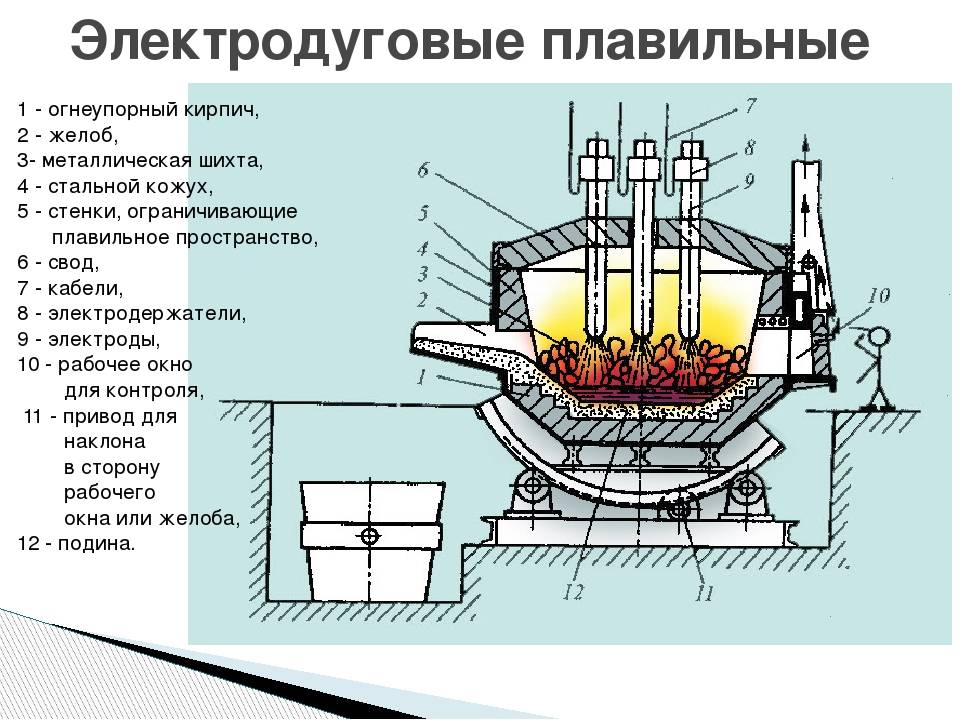

In [5]:
display(Image('https://sauna-pod-klyuch.ru/wp-content/uploads/8/7/9/87989688330d5b48c2e0c0dbd261b062.jpeg'))

# 1. Таблица data_arc

Изучу таблицу data_arc, в которой хранятся данные об электродах.

In [6]:
try:  
    df_arc = pd.read_csv('D:/steel/data_arc.csv')
except OSError as e:
    df_arc = pd.read_csv('/datasets/final_steel/data_arc.csv')
display(df_arc.head(10))
display(df_arc.tail(10))
display(df_arc.sample(10))

,key,Начало нагрева дугой,Конец нагрева дугой,Активная мощность,Реактивная мощность
0,1,2019-05-03 11:02:14,2019-05-03 11:06:02,0.976059,0.687084
1,1,2019-05-03 11:07:28,2019-05-03 11:10:33,0.805607,0.520285
2,1,2019-05-03 11:11:44,2019-05-03 11:14:36,0.744363,0.498805
3,1,2019-05-03 11:18:14,2019-05-03 11:24:19,1.659363,1.062669
4,1,2019-05-03 11:26:09,2019-05-03 11:28:37,0.692755,0.414397
5,2,2019-05-03 11:34:14,2019-05-03 11:36:31,0.438063,0.283043
6,2,2019-05-03 11:38:50,2019-05-03 11:44:28,1.296415,0.892914
7,2,2019-05-03 11:46:19,2019-05-03 11:48:25,0.490377,0.305281
8,2,2019-05-03 11:49:48,2019-05-03 11:53:18,0.827743,0.516874
9,3,2019-05-03 12:06:54,2019-05-03 12:11:34,1.062053,0.671494


,key,Начало нагрева дугой,Конец нагрева дугой,Активная мощность,Реактивная мощность
14866,3240,2019-09-01 02:35:24,2019-09-01 02:37:25,0.411601,0.274390
14867,3240,2019-09-01 02:40:55,2019-09-01 02:43:28,0.521811,0.378517
14868,3240,2019-09-01 03:08:38,2019-09-01 03:11:08,0.518065,0.528780
14869,3240,2019-09-01 03:12:34,2019-09-01 03:17:08,0.983723,0.884585
14870,3240,2019-09-01 03:31:47,2019-09-01 03:34:08,0.548882,0.416994
14871,3241,2019-09-01 03:58:58,2019-09-01 04:01:35,0.533670,0.354439
14872,3241,2019-09-01 04:05:04,2019-09-01 04:08:04,0.676604,0.523631
14873,3241,2019-09-01 04:16:41,2019-09-01 04:19:45,0.733899,0.475654
14874,3241,2019-09-01 04:31:51,2019-09-01 04:32:48,0.220694,0.145768
14875,3241,2019-09-01 04:34:47,2019-09-01 04:36:08,0.306580,0.196708


,key,Начало нагрева дугой,Конец нагрева дугой,Активная мощность,Реактивная мощность
12936,2811,2019-08-17 10:41:54,2019-08-17 10:45:28,0.745961,0.598990
6596,1434,2019-06-23 23:23:19,2019-06-23 23:25:35,0.531578,0.553873
12342,2681,2019-08-12 13:37:32,2019-08-12 13:39:37,0.416658,0.326205
10491,2281,2019-07-29 07:14:46,2019-07-29 07:17:00,0.474409,0.323987
413,90,2019-05-06 12:30:31,2019-05-06 12:32:42,0.446662,0.360788
5148,1118,2019-06-13 01:23:23,2019-06-13 01:24:26,0.252264,0.181161
4558,985,2019-06-08 12:09:18,2019-06-08 12:11:20,0.401113,0.292459
13506,2932,2019-08-21 20:25:22,2019-08-21 20:31:14,1.192940,1.045182
11830,2571,2019-08-08 19:19:39,2019-08-08 19:24:56,1.119432,0.866879
2992,650,2019-05-27 07:59:46,2019-05-27 08:02:22,0.695922,0.473738


Таблица состоит из следующих столбцов:
- "key" - содержит номер партии;
- "Начало нагрева дугой" - дата начала нагрева графитовыми электродами;
- "Конец нагрева дугой" - дата окончания нагрева графитовыми электродами;
- "Активная мощность" - среднее за период Τ значение мгновенной мощности, кВт;

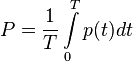

In [7]:
display(Image('http://electrokaprizam.net/f1.gif'))

- "Реактивная мощность" -  величина, характеризующая нагрузки, создаваемые в электротехнических устройствах колебаниями энергии электромагнитного поля в цепи синусоидального переменного тока, вар.

In [8]:
display(Image('http://electrokaprizam.net/f5.gif'))

In [9]:
display(df_arc.info())

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 14876 entries, 0 to 14875
Data columns (total 5 columns):
 #   Column                Non-Null Count  Dtype  
---  ------                --------------  -----  
 0   key                   14876 non-null  int64  
 1   Начало нагрева дугой  14876 non-null  object 
 2   Конец нагрева дугой   14876 non-null  object 
 3   Активная мощность     14876 non-null  float64
 4   Реактивная мощность   14876 non-null  float64
dtypes: float64(2), int64(1), object(2)
memory usage: 581.2+ KB


None

В таблице 14876 строк, пропуски в данных отсутствуют.

In [10]:
display(df_arc.describe())

,key,Активная мощность,Реактивная мощность
count,14876.000000,14876.000000,14876.000000
mean,1615.220422,0.670441,0.452592
std,934.571502,0.408159,5.878702
min,1.000000,0.030002,-715.504924
25%,806.000000,0.395297,0.290991
50%,1617.000000,0.555517,0.415962
75%,2429.000000,0.857034,0.637371
max,3241.000000,3.731596,2.676388


In [11]:
def graph(data, column, x):
    data[column].hist(bins=100, figsize=(15,8));
    plt.title(column);
    plt.xlabel(x);
    plt.ylabel("Количество значений");
    plt.style.use('seaborn');

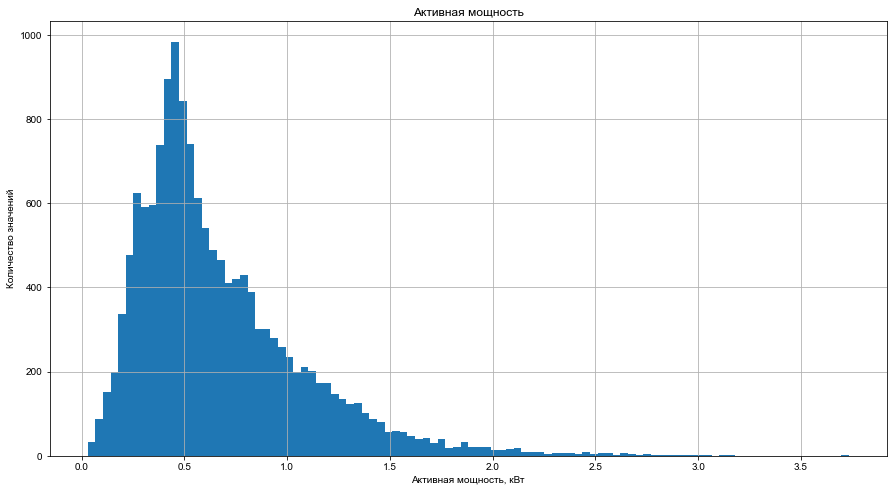

In [12]:
graph(df_arc, "Активная мощность", "Активная мощность, кВт")

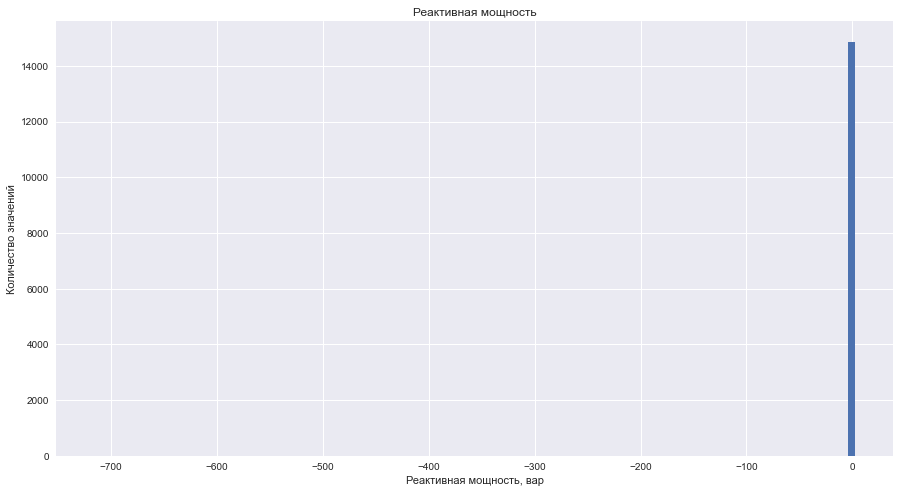

In [13]:
graph(df_arc, 'Реактивная мощность', "Реактивная мощность, вар")

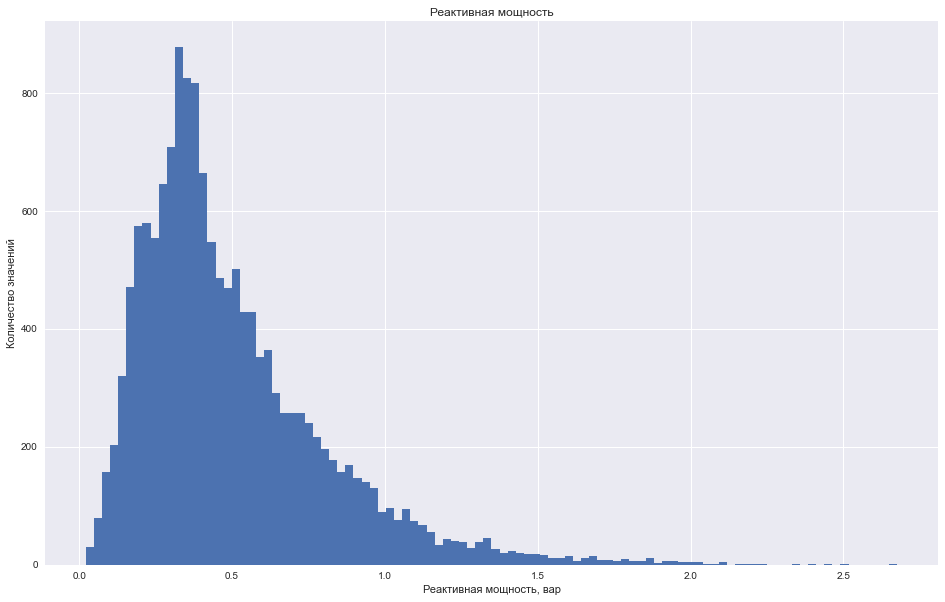

In [14]:
df_arc[df_arc['Реактивная мощность'] > 0]['Реактивная мощность'].hist(bins=100, figsize=(16,10));
plt.title("Реактивная мощность");
plt.xlabel("Реактивная мощность, вар");
plt.ylabel("Количество значений");

Значения активной мощности не имеют выбросов и артефактных значений.

Значения реактивной мощности имеют одно большое отрицательное значение, это явный выброс.

Оба графика похожи друг на друга так как обе мощности связаны через формулу полной мощности.

# 1.1 Вывод по таблице data_arc

1. Необходимо удалить ключ с выбросом в столбце с реактивной мощностью.
2. Добавить новые признаки (время нагрева, полная мощность, мощность на единицу времени).
3. Оставить в таблице по одной строке для каждого ключа, найдя средние мощности и просуммировав время нагрева.

# 2. Таблица data_bulk

Изучу таблицу data_bulk, в которой хранятся данные об объеме подачи сыпучих веществ.

In [15]:
try:  
    df_bulk = pd.read_csv('D:/steel/data_bulk.csv')
except OSError as e:
    df_bulk = pd.read_csv('/datasets/final_steel/data_bulk.csv')
display(df_bulk.head(10))
display(df_bulk.tail(10))
display(df_bulk.sample(10))

,key,Bulk 1,Bulk 2,Bulk 3,Bulk 4,Bulk 5,Bulk 6,Bulk 7,Bulk 8,Bulk 9,Bulk 10,Bulk 11,Bulk 12,Bulk 13,Bulk 14,Bulk 15
0,1,NaN,NaN,NaN,43.0,NaN,NaN,NaN,NaN,NaN,NaN,NaN,206.0,NaN,150.0,154.0
1,2,NaN,NaN,NaN,73.0,NaN,NaN,NaN,NaN,NaN,NaN,NaN,206.0,NaN,149.0,154.0
2,3,NaN,NaN,NaN,34.0,NaN,NaN,NaN,NaN,NaN,NaN,NaN,205.0,NaN,152.0,153.0
3,4,NaN,NaN,NaN,81.0,NaN,NaN,NaN,NaN,NaN,NaN,NaN,207.0,NaN,153.0,154.0
4,5,NaN,NaN,NaN,78.0,NaN,NaN,NaN,NaN,NaN,NaN,NaN,203.0,NaN,151.0,152.0
5,6,NaN,NaN,NaN,117.0,NaN,NaN,NaN,NaN,NaN,NaN,NaN,204.0,NaN,201.0,154.0
6,7,NaN,NaN,NaN,117.0,NaN,NaN,NaN,NaN,NaN,NaN,NaN,204.0,NaN,152.0,154.0
7,8,NaN,NaN,NaN,99.0,NaN,NaN,NaN,NaN,NaN,NaN,NaN,410.0,NaN,252.0,153.0
8,9,NaN,NaN,NaN,117.0,NaN,NaN,NaN,NaN,NaN,NaN,NaN,107.0,NaN,99.0,203.0
9,10,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,203.0,NaN,102.0,204.0


,key,Bulk 1,Bulk 2,Bulk 3,Bulk 4,Bulk 5,Bulk 6,Bulk 7,Bulk 8,Bulk 9,Bulk 10,Bulk 11,Bulk 12,Bulk 13,Bulk 14,Bulk 15
3119,3232,NaN,NaN,22.0,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,252.0,NaN,92.0,204.0
3120,3233,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,254.0,NaN,114.0,204.0
3121,3234,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,262.0,204.0
3122,3235,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,204.0,NaN,118.0,206.0
3123,3236,NaN,NaN,42.0,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,258.0,NaN,132.0,208.0
3124,3237,NaN,NaN,170.0,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,252.0,NaN,130.0,206.0
3125,3238,NaN,NaN,126.0,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,254.0,NaN,108.0,106.0
3126,3239,NaN,NaN,NaN,NaN,NaN,114.0,NaN,NaN,NaN,NaN,NaN,158.0,NaN,270.0,88.0
3127,3240,NaN,NaN,NaN,NaN,NaN,26.0,NaN,NaN,NaN,NaN,NaN,NaN,NaN,192.0,54.0
3128,3241,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,180.0,52.0


,key,Bulk 1,Bulk 2,Bulk 3,Bulk 4,Bulk 5,Bulk 6,Bulk 7,Bulk 8,Bulk 9,Bulk 10,Bulk 11,Bulk 12,Bulk 13,Bulk 14,Bulk 15
1264,1315,NaN,NaN,50.0,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
2204,2284,NaN,NaN,142.0,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,263.0,NaN,192.0,104.0
379,405,NaN,NaN,116.0,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,411.0,NaN,275.0,152.0
1690,1750,NaN,NaN,45.0,81.0,NaN,NaN,NaN,NaN,NaN,NaN,NaN,204.0,NaN,100.0,104.0
2161,2240,46.0,NaN,NaN,NaN,NaN,92.0,NaN,NaN,NaN,NaN,NaN,515.0,NaN,94.0,NaN
2235,2316,NaN,NaN,NaN,64.0,NaN,NaN,NaN,NaN,NaN,NaN,NaN,156.0,NaN,147.0,103.0
1995,2066,NaN,NaN,NaN,96.0,256.0,NaN,NaN,NaN,NaN,NaN,NaN,256.0,NaN,102.0,107.0
1742,1803,NaN,NaN,NaN,59.0,NaN,NaN,NaN,NaN,NaN,NaN,NaN,205.0,NaN,101.0,103.0
1898,1962,NaN,NaN,NaN,21.0,NaN,NaN,NaN,NaN,NaN,91.0,NaN,NaN,NaN,NaN,NaN
2022,2093,NaN,NaN,NaN,151.0,NaN,NaN,NaN,NaN,NaN,NaN,NaN,255.0,NaN,97.0,NaN


Таблица состоит из следующих столбцов:

- "key" - содержит номер партии;
- "Bulk 1 - Bulk 15" - NaN говорит о том, что в конкретную партию конкретное вещество не добавлялось.

In [16]:
display(df_bulk.info())

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 3129 entries, 0 to 3128
Data columns (total 16 columns):
 #   Column   Non-Null Count  Dtype  
---  ------   --------------  -----  
 0   key      3129 non-null   int64  
 1   Bulk 1   252 non-null    float64
 2   Bulk 2   22 non-null     float64
 3   Bulk 3   1298 non-null   float64
 4   Bulk 4   1014 non-null   float64
 5   Bulk 5   77 non-null     float64
 6   Bulk 6   576 non-null    float64
 7   Bulk 7   25 non-null     float64
 8   Bulk 8   1 non-null      float64
 9   Bulk 9   19 non-null     float64
 10  Bulk 10  176 non-null    float64
 11  Bulk 11  177 non-null    float64
 12  Bulk 12  2450 non-null   float64
 13  Bulk 13  18 non-null     float64
 14  Bulk 14  2806 non-null   float64
 15  Bulk 15  2248 non-null   float64
dtypes: float64(15), int64(1)
memory usage: 391.2 KB


None

В таблице присутствует большое количество NaN.

Некоторые вещества использовались сильно меньше, чем все остальные.

In [17]:
display(df_bulk.describe())

,key,Bulk 1,Bulk 2,Bulk 3,Bulk 4,Bulk 5,Bulk 6,Bulk 7,Bulk 8,Bulk 9,Bulk 10,Bulk 11,Bulk 12,Bulk 13,Bulk 14,Bulk 15
count,3129.000000,252.000000,22.000000,1298.000000,1014.000000,77.000000,576.000000,25.000000,1.0,19.000000,176.000000,177.000000,2450.000000,18.000000,2806.000000,2248.000000
mean,1624.383509,39.242063,253.045455,113.879045,104.394477,107.025974,118.925347,305.600000,49.0,76.315789,83.284091,76.819209,260.471020,181.111111,170.284747,160.513345
std,933.337642,18.277654,21.180578,75.483494,48.184126,81.790646,72.057776,191.022904,NaN,21.720581,26.060347,59.655365,120.649269,46.088009,65.868652,51.765319
min,1.000000,10.000000,228.000000,6.000000,12.000000,11.000000,17.000000,47.000000,49.0,63.000000,24.000000,8.000000,53.000000,151.000000,16.000000,1.000000
25%,816.000000,27.000000,242.000000,58.000000,72.000000,70.000000,69.750000,155.000000,49.0,66.000000,64.000000,25.000000,204.000000,153.250000,119.000000,105.000000
50%,1622.000000,31.000000,251.500000,97.500000,102.000000,86.000000,100.000000,298.000000,49.0,68.000000,86.500000,64.000000,208.000000,155.500000,151.000000,160.000000
75%,2431.000000,46.000000,257.750000,152.000000,133.000000,132.000000,157.000000,406.000000,49.0,70.500000,102.000000,106.000000,316.000000,203.500000,205.750000,205.000000
max,3241.000000,185.000000,325.000000,454.000000,281.000000,603.000000,503.000000,772.000000,49.0,147.000000,159.000000,313.000000,1849.000000,305.000000,636.000000,405.000000


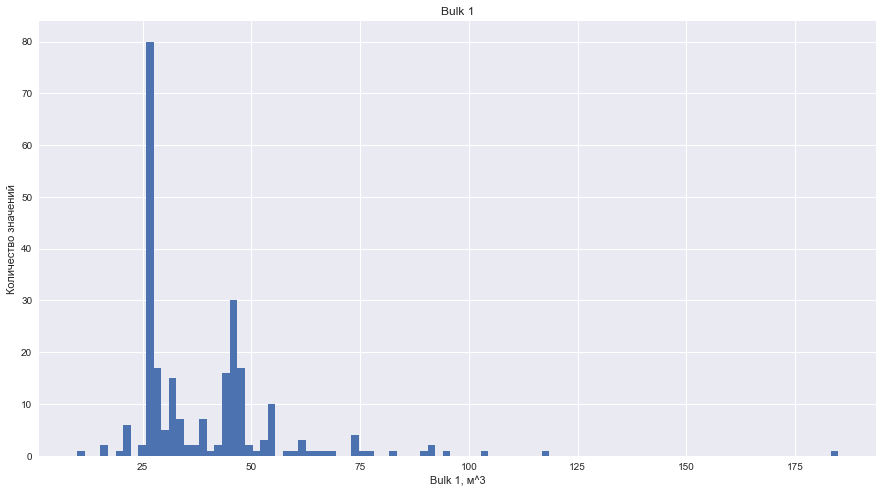

In [18]:
graph(df_bulk, "Bulk 1", "Bulk 1, м^3")

Имеется выбивающееся значение.

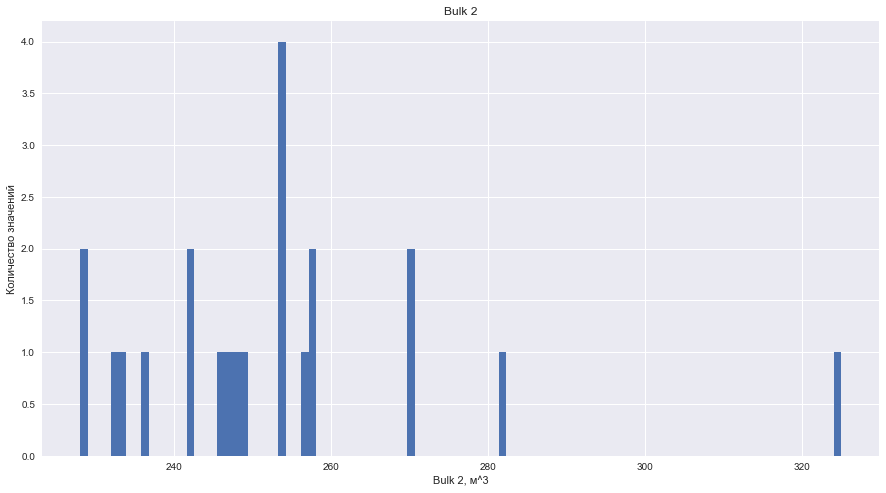

In [19]:
graph(df_bulk, "Bulk 2", "Bulk 2, м^3")

Данное вещество использовалось не часто и имеется выбивающееся значение.

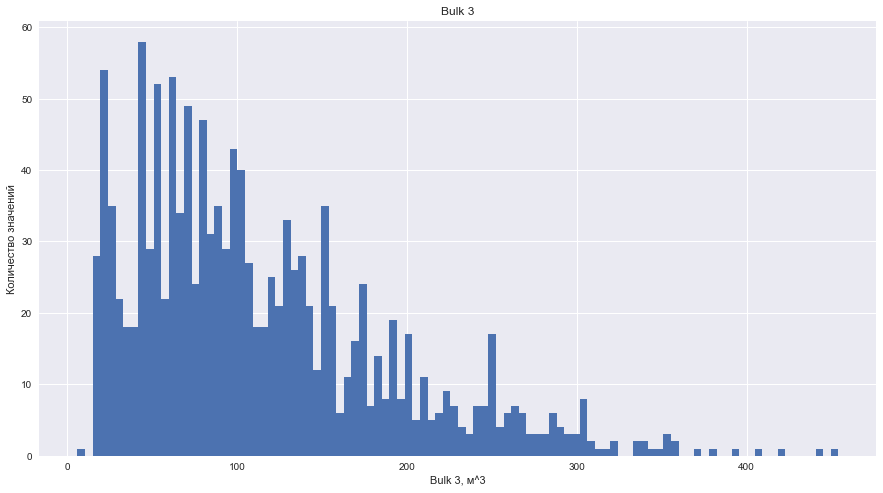

In [20]:
graph(df_bulk, "Bulk 3", "Bulk 3, м^3")

С данными все в порядке.

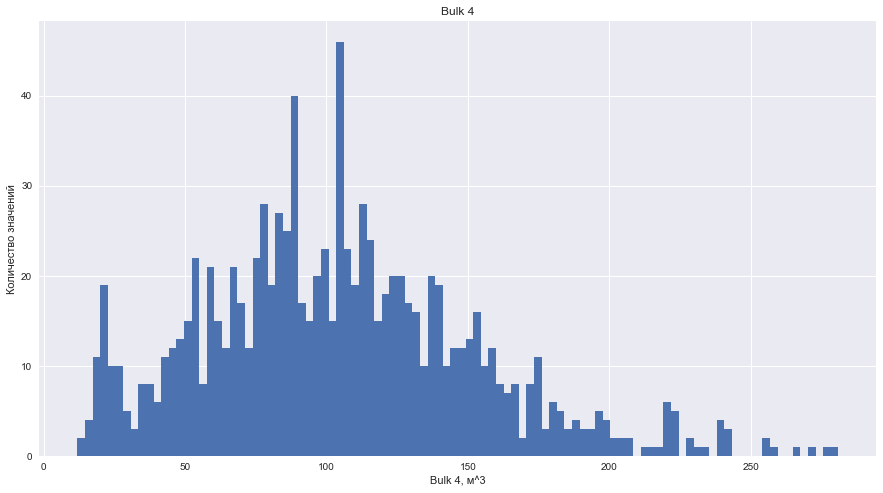

In [21]:
graph(df_bulk, "Bulk 4", "Bulk 4, м^3")

С данными все в порядке.

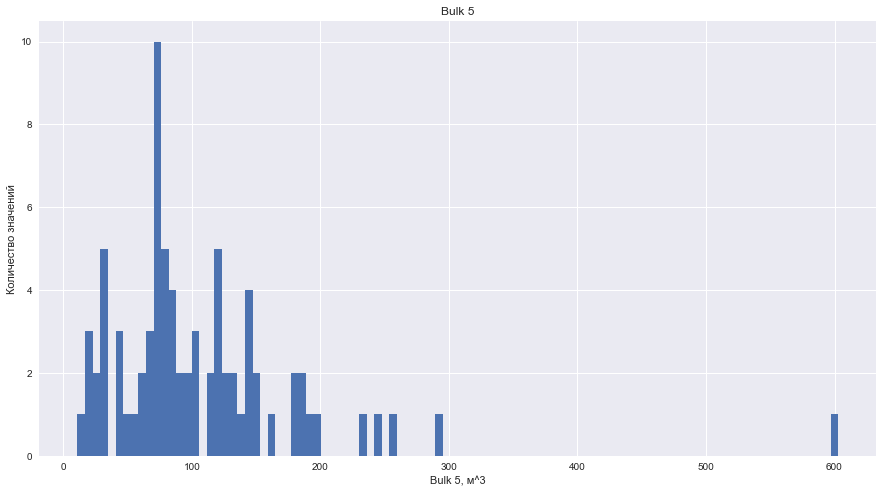

In [22]:
graph(df_bulk, "Bulk 5", "Bulk 5, м^3")

Имеется выбивающееся значение.

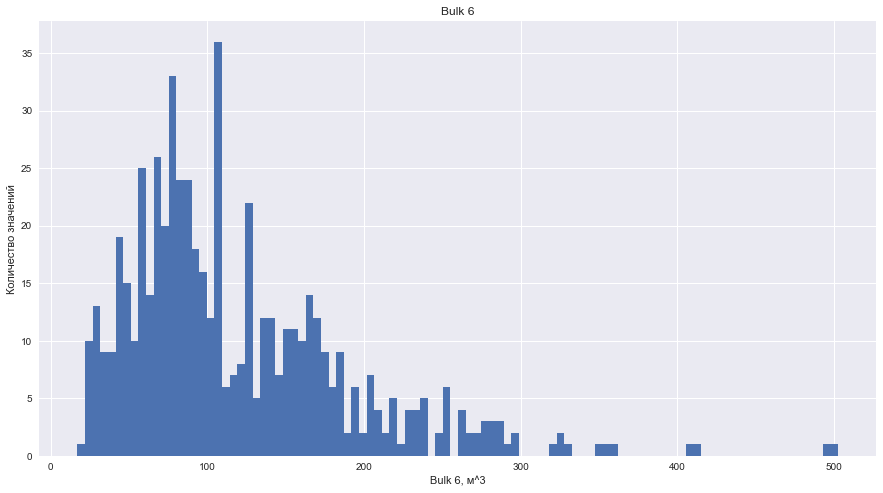

In [23]:
graph(df_bulk, "Bulk 6", "Bulk 6, м^3")

Имеется выбивающееся значение.

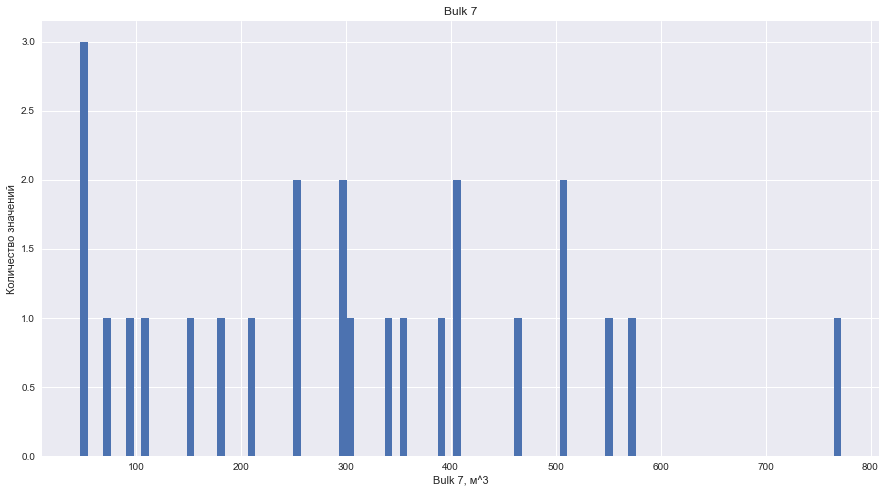

In [24]:
graph(df_bulk, "Bulk 7", "Bulk 7, м^3")

Вещество используется редко.

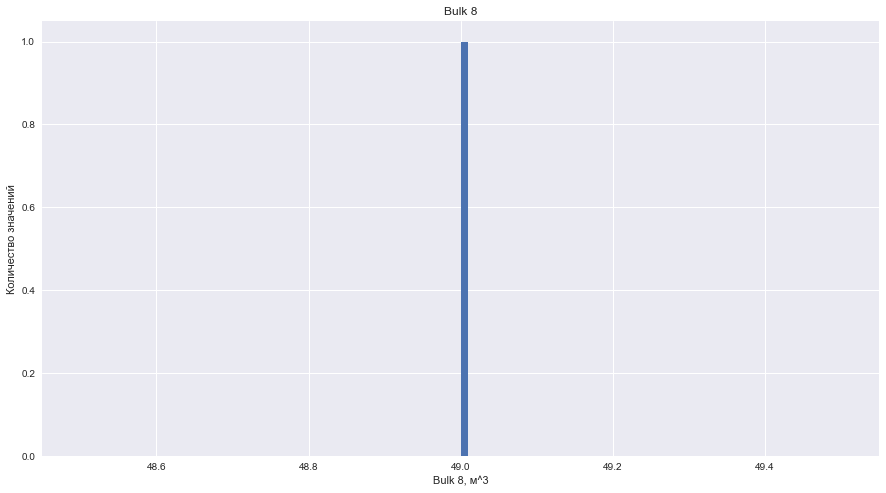

In [25]:
graph(df_bulk, "Bulk 8", "Bulk 8, м^3")

Вещество используется редко.

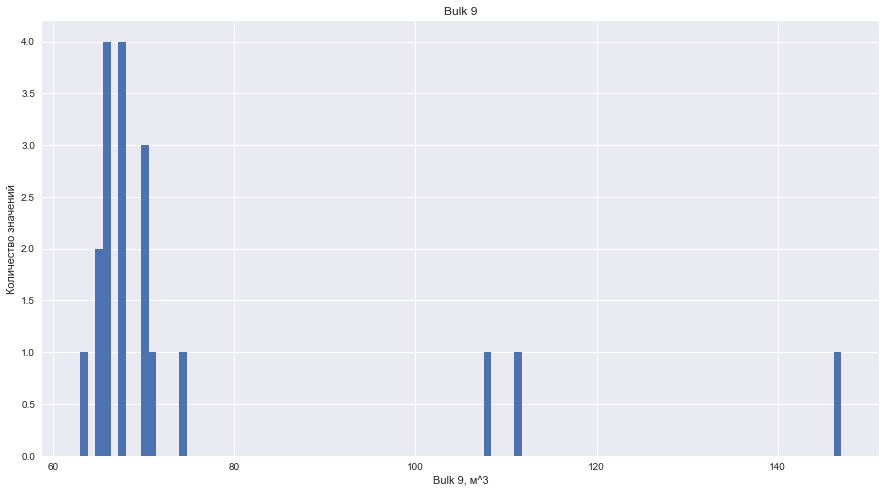

In [26]:
graph(df_bulk, "Bulk 9", "Bulk 9, м^3")

Вещество используется редко.

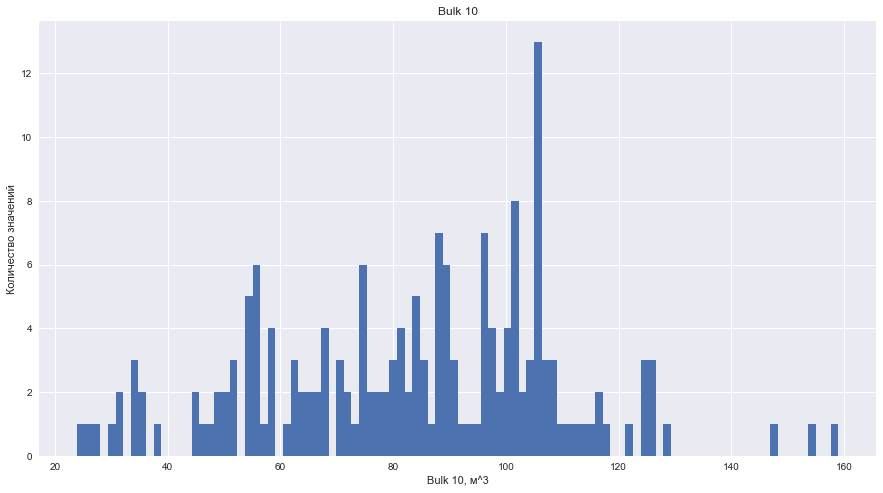

In [27]:
graph(df_bulk, "Bulk 10", "Bulk 10, м^3")

С данными всё в порядке.

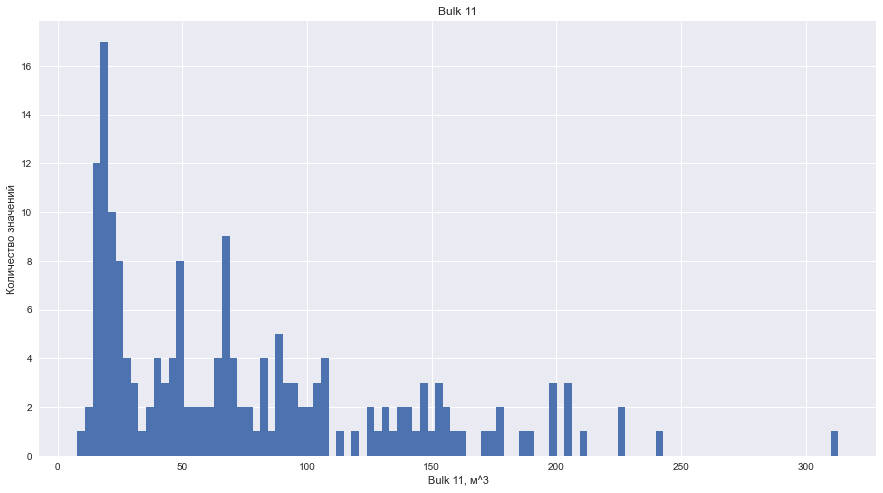

In [28]:
graph(df_bulk, "Bulk 11", "Bulk 11, м^3")

Имеется выбивающееся значение.

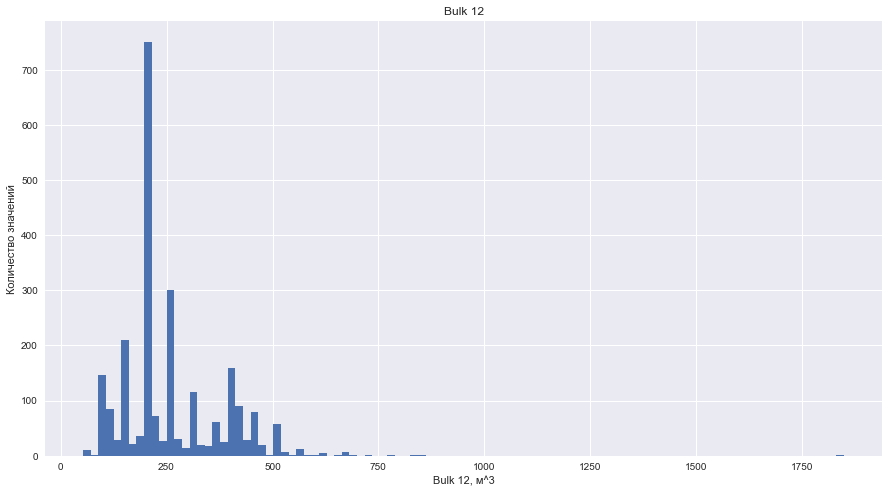

In [29]:
graph(df_bulk, "Bulk 12", "Bulk 12, м^3")

Имеется выбивающееся значение.

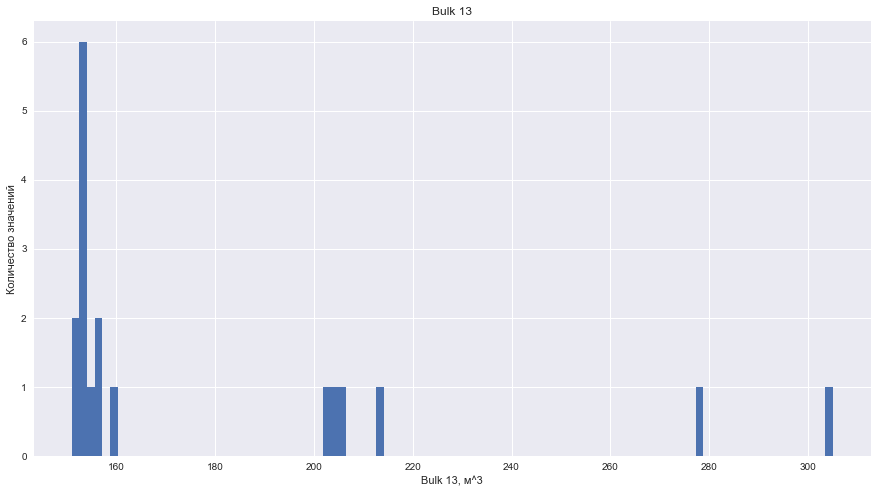

In [30]:
graph(df_bulk, "Bulk 13", "Bulk 13, м^3")

Вещество используется редко.

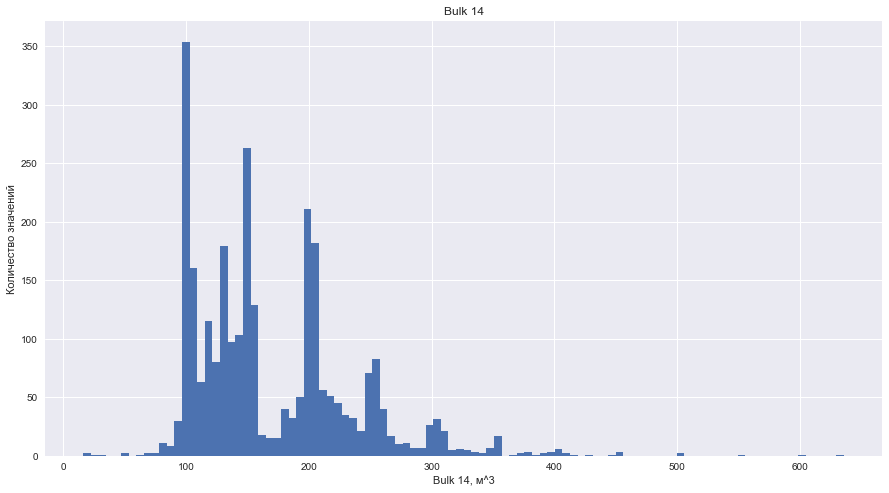

In [31]:
graph(df_bulk, "Bulk 14", "Bulk 14, м^3")

Имеются выбивающеися значения.

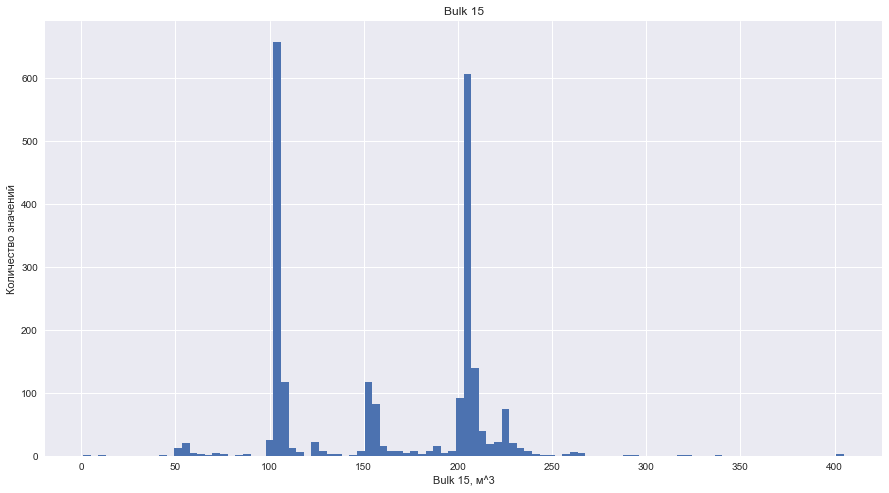

In [32]:
graph(df_bulk, "Bulk 15", "Bulk 15, м^3")

Имеются выбивающеися значения.

# 2.1 Вывод по таблице data_bulk

1. Необходимо удалить из таблицы малоиспользуемые вещества.
2. Оставить в таблице по одной строке для каждого ключа, найдя общий объем смесей.
3. Все выбивающиеся значения необходимо либо заменить, либо удалить ключ.

# 3. Таблица data_bulk_time

Изучу таблицу data_bulk_time, в которой хранятся данные о времени подаче сыпучих материалов.

In [33]:
try:  
    df_bulk_time = pd.read_csv('D:/steel/data_bulk_time.csv')
except OSError as e:
    df_bulk_time = pd.read_csv('/datasets/final_steel/data_bulk_time.csv')
display(df_bulk_time.head(10))
display(df_bulk_time.tail(10))
display(df_bulk_time.sample(10))

,key,Bulk 1,Bulk 2,Bulk 3,Bulk 4,Bulk 5,Bulk 6,Bulk 7,Bulk 8,Bulk 9,Bulk 10,Bulk 11,Bulk 12,Bulk 13,Bulk 14,Bulk 15
0,1,NaN,NaN,NaN,2019-05-03 11:21:30,NaN,NaN,NaN,NaN,NaN,NaN,NaN,2019-05-03 11:03:52,NaN,2019-05-03 11:03:52,2019-05-03 11:03:52
1,2,NaN,NaN,NaN,2019-05-03 11:46:38,NaN,NaN,NaN,NaN,NaN,NaN,NaN,2019-05-03 11:40:20,NaN,2019-05-03 11:40:20,2019-05-03 11:40:20
2,3,NaN,NaN,NaN,2019-05-03 12:31:06,NaN,NaN,NaN,NaN,NaN,NaN,NaN,2019-05-03 12:09:40,NaN,2019-05-03 12:09:40,2019-05-03 12:09:40
3,4,NaN,NaN,NaN,2019-05-03 12:48:43,NaN,NaN,NaN,NaN,NaN,NaN,NaN,2019-05-03 12:41:24,NaN,2019-05-03 12:41:24,2019-05-03 12:41:24
4,5,NaN,NaN,NaN,2019-05-03 13:18:50,NaN,NaN,NaN,NaN,NaN,NaN,NaN,2019-05-03 13:12:56,NaN,2019-05-03 13:12:56,2019-05-03 13:12:56
5,6,NaN,NaN,NaN,2019-05-03 13:59:24,NaN,NaN,NaN,NaN,NaN,NaN,NaN,2019-05-03 13:53:27,NaN,2019-05-03 13:53:27,2019-05-03 13:53:27
6,7,NaN,NaN,NaN,2019-05-03 14:29:14,NaN,NaN,NaN,NaN,NaN,NaN,NaN,2019-05-03 14:22:19,NaN,2019-05-03 14:22:19,2019-05-03 14:22:19
7,8,NaN,NaN,NaN,2019-05-03 15:04:05,NaN,NaN,NaN,NaN,NaN,NaN,NaN,2019-05-03 14:55:46,NaN,2019-05-03 14:55:46,2019-05-03 14:55:46
8,9,NaN,NaN,NaN,2019-05-03 15:47:34,NaN,NaN,NaN,NaN,NaN,NaN,NaN,2019-05-03 15:41:00,NaN,2019-05-03 15:41:00,2019-05-03 15:41:00
9,10,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,2019-05-03 16:18:52,NaN,2019-05-03 16:18:52,2019-05-03 16:18:52


,key,Bulk 1,Bulk 2,Bulk 3,Bulk 4,Bulk 5,Bulk 6,Bulk 7,Bulk 8,Bulk 9,Bulk 10,Bulk 11,Bulk 12,Bulk 13,Bulk 14,Bulk 15
3119,3232,NaN,NaN,2019-08-31 20:03:29,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,2019-08-31 19:58:36,NaN,2019-08-31 19:58:36,2019-08-31 19:58:36
3120,3233,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,2019-08-31 20:26:21,NaN,2019-08-31 20:26:21,2019-08-31 20:26:21
3121,3234,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,2019-08-31 20:58:45,2019-08-31 20:58:45
3122,3235,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,2019-08-31 21:29:26,NaN,2019-08-31 21:29:26,2019-08-31 21:29:26
3123,3236,NaN,NaN,2019-08-31 22:20:30,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,2019-08-31 22:11:55,NaN,2019-08-31 22:11:55,2019-08-31 22:11:55
3124,3237,NaN,NaN,2019-08-31 22:51:28,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,2019-08-31 22:46:52,NaN,2019-08-31 22:46:52,2019-08-31 22:46:52
3125,3238,NaN,NaN,2019-08-31 23:39:11,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,2019-08-31 23:33:09,NaN,2019-08-31 23:33:09,2019-08-31 23:33:09
3126,3239,NaN,NaN,NaN,NaN,NaN,2019-09-01 01:51:58,NaN,NaN,NaN,NaN,NaN,2019-09-01 01:39:41,NaN,2019-09-01 01:33:25,2019-09-01 01:33:25
3127,3240,NaN,NaN,NaN,NaN,NaN,2019-09-01 03:12:40,NaN,NaN,NaN,NaN,NaN,NaN,NaN,2019-09-01 02:41:27,2019-09-01 02:41:27
3128,3241,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,2019-09-01 04:05:34,2019-09-01 04:05:34


,key,Bulk 1,Bulk 2,Bulk 3,Bulk 4,Bulk 5,Bulk 6,Bulk 7,Bulk 8,Bulk 9,Bulk 10,Bulk 11,Bulk 12,Bulk 13,Bulk 14,Bulk 15
2252,2333,NaN,NaN,NaN,2019-07-31 02:34:59,NaN,NaN,NaN,NaN,NaN,NaN,NaN,2019-07-31 02:30:19,NaN,2019-07-31 02:30:19,2019-07-31 02:30:19
1365,1418,2019-06-23 10:32:21,NaN,2019-06-23 10:36:40,NaN,NaN,2019-06-23 10:36:40,NaN,NaN,NaN,NaN,NaN,2019-06-23 10:32:21,NaN,2019-06-23 10:32:21,2019-06-23 10:32:21
611,641,NaN,NaN,NaN,2019-05-27 01:03:12,NaN,NaN,NaN,NaN,NaN,NaN,NaN,2019-05-26 20:42:03,2019-05-26 20:42:03,NaN,2019-05-26 20:42:03
799,834,NaN,NaN,2019-06-03 07:21:03,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,2019-06-03 07:17:24,NaN,2019-06-03 07:17:24,2019-06-03 07:17:24
284,303,2019-05-14 16:24:02,NaN,2019-05-14 16:38:27,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,2019-05-14 16:20:27,NaN,2019-05-14 16:20:27,2019-05-14 16:20:27
1192,1241,2019-06-17 06:12:53,NaN,NaN,2019-06-17 06:16:17,NaN,NaN,NaN,NaN,NaN,NaN,NaN,2019-06-17 06:09:20,NaN,2019-06-17 06:09:20,2019-06-17 06:09:20
3116,3229,NaN,NaN,2019-08-31 18:21:28,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,2019-08-31 18:15:33,NaN,2019-08-31 18:15:33,2019-08-31 18:15:33
164,178,NaN,NaN,NaN,2019-05-10 00:42:36,NaN,NaN,NaN,NaN,NaN,NaN,NaN,2019-05-10 00:36:55,NaN,2019-05-10 00:36:55,2019-05-10 00:36:55
3088,3198,2019-08-30 19:23:57,NaN,2019-08-30 19:32:40,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,2019-08-30 19:21:07,NaN,2019-08-30 19:21:07,2019-08-30 19:21:07
860,896,NaN,NaN,NaN,2019-06-05 10:10:13,NaN,NaN,NaN,NaN,NaN,NaN,NaN,2019-06-05 10:05:18,NaN,2019-06-05 10:05:18,2019-06-05 10:05:18


Таблица состоит из следующих столбцов:

- "key" - содержит номер партии;
- "Bulk 1 - Bulk 15" - NaN говорит о том, что в конкретную партию конкретное вещество не добавлялось.

In [34]:
display(df_bulk_time.info())

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 3129 entries, 0 to 3128
Data columns (total 16 columns):
 #   Column   Non-Null Count  Dtype 
---  ------   --------------  ----- 
 0   key      3129 non-null   int64 
 1   Bulk 1   252 non-null    object
 2   Bulk 2   22 non-null     object
 3   Bulk 3   1298 non-null   object
 4   Bulk 4   1014 non-null   object
 5   Bulk 5   77 non-null     object
 6   Bulk 6   576 non-null    object
 7   Bulk 7   25 non-null     object
 8   Bulk 8   1 non-null      object
 9   Bulk 9   19 non-null     object
 10  Bulk 10  176 non-null    object
 11  Bulk 11  177 non-null    object
 12  Bulk 12  2450 non-null   object
 13  Bulk 13  18 non-null     object
 14  Bulk 14  2806 non-null   object
 15  Bulk 15  2248 non-null   object
dtypes: int64(1), object(15)
memory usage: 391.2+ KB


None

В таблице присутствует большое количество NaN.

Некоторые вещества использовались сильно меньше, чем все остальные.

# 3.1 Вывод по таблице data_bulk_time

По данной таблице я проверю адекватность данных.

Так как есть сложности со снятием точного времени с датчиков, больше ни для чего эту таблицу я использовать не буду.

# 4. Таблица data_gas

Изучу таблицу data_gas, в которой хранятся данные о продувке сплава газом.

In [35]:
try:  
    df_gas = pd.read_csv('D:/steel/data_gas.csv')
except OSError as e:
    df_gas = pd.read_csv('/datasets/final_steel/data_gas.csv')
display(df_gas.head(10))
display(df_gas.tail(10))
display(df_gas.sample(10))

,key,Газ 1
0,1,29.749986
1,2,12.555561
2,3,28.554793
3,4,18.841219
4,5,5.413692
5,6,11.273392
6,7,9.836267
7,8,15.171553
8,9,8.216623
9,10,6.529891


,key,Газ 1
3229,3232,8.630453
3230,3233,7.366606
3231,3234,9.110702
3232,3235,5.710729
3233,3236,6.958647
3234,3237,5.543905
3235,3238,6.745669
3236,3239,16.023518
3237,3240,11.863103
3238,3241,12.680959


,key,Газ 1
771,774,7.648113
774,777,7.682889
1041,1044,11.668068
934,937,11.039876
3041,3044,12.465548
1836,1839,13.020285
3010,3013,16.132050
1741,1744,4.466374
838,841,8.370194
1247,1250,17.314788


Таблица состоит из следующих столбцов:

- "key" - содержит номер партии;
- "Газ 1" - количество газа, потраченного для продувки.

In [36]:
display(df_gas.info())

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 3239 entries, 0 to 3238
Data columns (total 2 columns):
 #   Column  Non-Null Count  Dtype  
---  ------  --------------  -----  
 0   key     3239 non-null   int64  
 1   Газ 1   3239 non-null   float64
dtypes: float64(1), int64(1)
memory usage: 50.7 KB


None

Пропуски в данных отсутствуют.

In [37]:
display(df_gas.describe())

,key,Газ 1
count,3239.000000,3239.000000
mean,1621.861377,11.002062
std,935.386334,6.220327
min,1.000000,0.008399
25%,812.500000,7.043089
50%,1622.000000,9.836267
75%,2431.500000,13.769915
max,3241.000000,77.995040


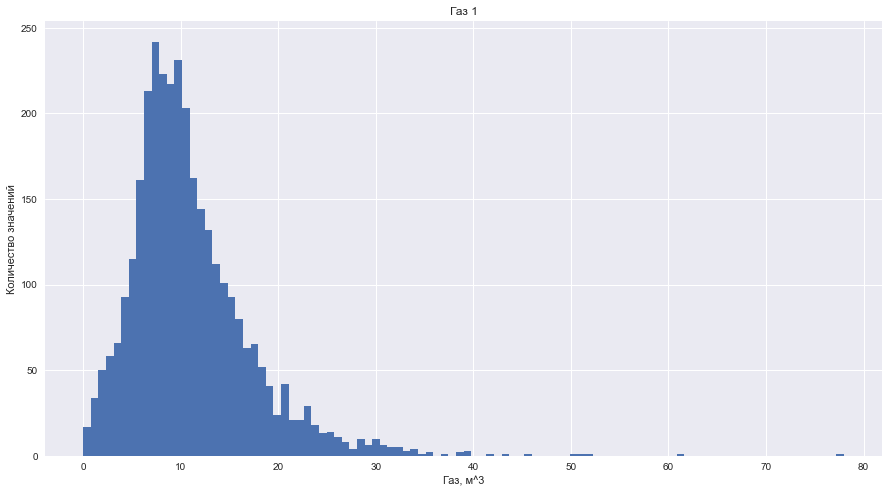

In [38]:
graph(df_gas, "Газ 1", "Газ, м^3")

Имеются выбивающиеся значения.

# 4.1 Вывод по таблице data_gas

1. Необходимо проверить строки с выбивающимися значениями, возможно было много итераций.

# 5. Таблица data_temp

Изучу таблицу data_temp, в которой хранятся результаты измерения температур.

In [39]:
try:  
    df_temp = pd.read_csv('D:/steel/data_temp.csv')
except OSError as e:
    df_temp = pd.read_csv('/datasets/final_steel/data_temp.csv')
display(df_temp.head(10))
display(df_temp.tail(10))
display(df_temp.sample(10))

,key,Время замера,Температура
0,1,2019-05-03 11:16:18,1571.0
1,1,2019-05-03 11:25:53,1604.0
2,1,2019-05-03 11:29:11,1618.0
3,1,2019-05-03 11:30:01,1601.0
4,1,2019-05-03 11:30:39,1613.0
5,2,2019-05-03 11:37:27,1581.0
6,2,2019-05-03 11:38:00,1577.0
7,2,2019-05-03 11:49:38,1589.0
8,2,2019-05-03 11:55:50,1604.0
9,2,2019-05-03 11:58:24,1608.0


,key,Время замера,Температура
15897,3240,2019-09-01 03:12:19,NaN
15898,3240,2019-09-01 03:19:09,NaN
15899,3240,2019-09-01 03:31:27,NaN
15900,3240,2019-09-01 03:34:31,NaN
15901,3240,2019-09-01 03:35:16,NaN
15902,3241,2019-09-01 04:03:30,1586.0
15903,3241,2019-09-01 04:16:12,NaN
15904,3241,2019-09-01 04:22:39,NaN
15905,3241,2019-09-01 04:33:42,NaN
15906,3241,2019-09-01 04:38:08,NaN


,key,Время замера,Температура
7321,1489,2019-06-26 02:04:04,1583.0
15547,3160,2019-08-29 09:30:12,NaN
15275,3103,2019-08-27 17:09:52,NaN
10500,2123,2019-07-24 06:13:19,1621.0
12539,2556,2019-08-08 02:43:11,NaN
1858,342,2019-05-16 04:13:30,1596.0
12946,2634,2019-08-10 20:57:08,1581.0
9229,1880,2019-07-09 06:23:15,1593.0
229,44,2019-05-04 22:44:29,1605.0
10448,2112,2019-07-23 22:31:05,1575.0


Таблица состоит из следующих столбцов:

- "key" - содержит номер партии;
- "Время замера" - время проведения замера температуры.
- "Температура" - конечная температура стли (ключевой признак), градусы Цельсия.

In [40]:
display(df_temp.info())

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 15907 entries, 0 to 15906
Data columns (total 3 columns):
 #   Column        Non-Null Count  Dtype  
---  ------        --------------  -----  
 0   key           15907 non-null  int64  
 1   Время замера  15907 non-null  object 
 2   Температура   13006 non-null  float64
dtypes: float64(1), int64(1), object(1)
memory usage: 372.9+ KB


None

В столбце "Температура" имеются NaN.

In [41]:
display(df_temp.describe())

,key,Температура
count,15907.000000,13006.000000
mean,1607.880870,1591.840920
std,942.212073,21.375851
min,1.000000,1191.000000
25%,790.000000,1581.000000
50%,1618.000000,1591.000000
75%,2427.000000,1601.000000
max,3241.000000,1705.000000


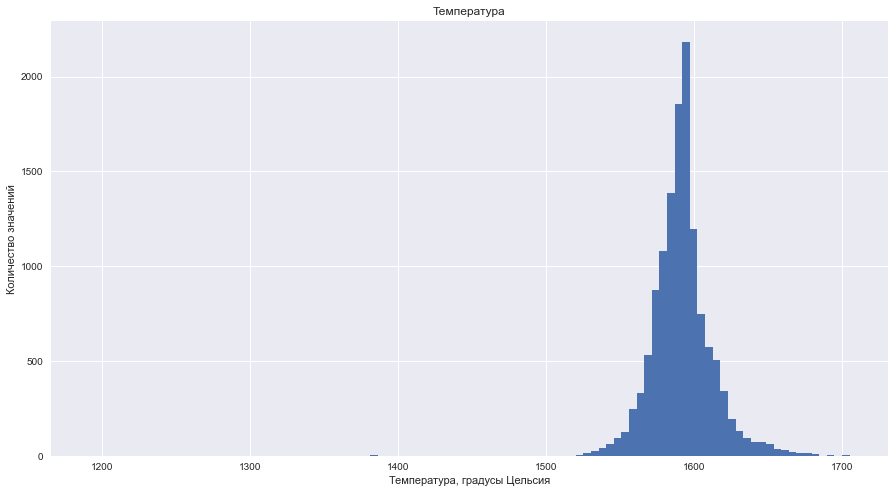

In [42]:
graph(df_temp, "Температура", "Температура, градусы Цельсия")

В таблице присутствует температура ниже 1500 градусов Цельсия.

# 5.1 Вывод по таблице data_temp

1. Привести таблицу к виду - ключ, первый замер температуры, конечный замер температуры.
2. Ключи, чьи значения температуры ниже 1500 градусов Цельсия необходимо исключить из таблицы.

# 6. Таблица data_wire

Изучу таблицу data_wire, в которой хранятся данные об объеме проволочных материалов.

In [43]:
try:  
    df_wire = pd.read_csv('D:/steel/data_wire.csv')
except OSError as e:
    df_wire = pd.read_csv('/datasets/final_steel/data_wire.csv')
display(df_wire.head(10))
display(df_wire.tail(10))
display(df_wire.sample(10))

,key,Wire 1,Wire 2,Wire 3,Wire 4,Wire 5,Wire 6,Wire 7,Wire 8,Wire 9
0,1,60.059998,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
1,2,96.052315,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
2,3,91.160157,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
3,4,89.063515,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
4,5,89.238236,9.114560,NaN,NaN,NaN,NaN,NaN,NaN,NaN
5,6,99.109917,9.114560,NaN,NaN,NaN,NaN,NaN,NaN,NaN
6,7,98.061600,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
7,8,155.282394,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
8,9,113.393279,9.143681,NaN,NaN,NaN,NaN,NaN,NaN,NaN
9,10,81.244796,12.376000,NaN,NaN,NaN,NaN,NaN,NaN,NaN


,key,Wire 1,Wire 2,Wire 3,Wire 4,Wire 5,Wire 6,Wire 7,Wire 8,Wire 9
3071,3232,15.069600,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
3072,3233,107.147033,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
3073,3234,110.160957,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
3074,3235,125.099525,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
3075,3236,101.162880,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
3076,3237,38.088959,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
3077,3238,56.128799,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
3078,3239,143.357761,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
3079,3240,34.070400,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
3080,3241,63.117595,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN


,key,Wire 1,Wire 2,Wire 3,Wire 4,Wire 5,Wire 6,Wire 7,Wire 8,Wire 9
1670,1756,70.106399,90.118080,NaN,NaN,NaN,NaN,NaN,NaN,NaN
1136,1204,124.113602,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
2742,2895,85.088638,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
2191,2302,66.000473,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
1163,1231,175.219197,31.275921,NaN,NaN,NaN,NaN,NaN,NaN,NaN
1747,1837,193.424392,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
582,618,70.199997,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
30,31,96.139680,27.023361,NaN,NaN,NaN,NaN,NaN,NaN,NaN
1844,1934,149.123535,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
929,989,127.155593,85.201996,NaN,NaN,NaN,NaN,NaN,NaN,NaN


Таблица состоит из следующих столбцов:

- "key" - содержит номер партии;
- "Wire 1 - Wire 9" - NaN говорит о том, что в конкретную партию конкретные проволочные материалы не добавлялись.

In [44]:
display(df_wire.info())

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 3081 entries, 0 to 3080
Data columns (total 10 columns):
 #   Column  Non-Null Count  Dtype  
---  ------  --------------  -----  
 0   key     3081 non-null   int64  
 1   Wire 1  3055 non-null   float64
 2   Wire 2  1079 non-null   float64
 3   Wire 3  63 non-null     float64
 4   Wire 4  14 non-null     float64
 5   Wire 5  1 non-null      float64
 6   Wire 6  73 non-null     float64
 7   Wire 7  11 non-null     float64
 8   Wire 8  19 non-null     float64
 9   Wire 9  29 non-null     float64
dtypes: float64(9), int64(1)
memory usage: 240.8 KB


None

В таблице присутствует большое количество NaN.

Некоторые проволочные материалы использовались сильно меньше, чем все остальные

In [45]:
display(df_wire.describe())

,key,Wire 1,Wire 2,Wire 3,Wire 4,Wire 5,Wire 6,Wire 7,Wire 8,Wire 9
count,3081.000000,3055.000000,1079.000000,63.000000,14.000000,1.000,73.000000,11.000000,19.000000,29.000000
mean,1623.426485,100.895853,50.577323,189.482681,57.442842,15.132,48.016974,10.039007,53.625193,34.155752
std,932.996726,42.012518,39.320216,99.513444,28.824667,NaN,33.919845,8.610584,16.881728,19.931616
min,1.000000,1.918800,0.030160,0.144144,24.148801,15.132,0.034320,0.234208,45.076721,4.622800
25%,823.000000,72.115684,20.193680,95.135044,40.807002,15.132,25.053600,6.762756,46.094879,22.058401
50%,1619.000000,100.158234,40.142956,235.194977,45.234282,15.132,42.076324,9.017009,46.279999,30.066399
75%,2434.000000,126.060483,70.227558,276.252014,76.124619,15.132,64.212723,11.886057,48.089603,43.862003
max,3241.000000,330.314424,282.780152,385.008668,113.231044,15.132,180.454575,32.847674,102.762401,90.053604


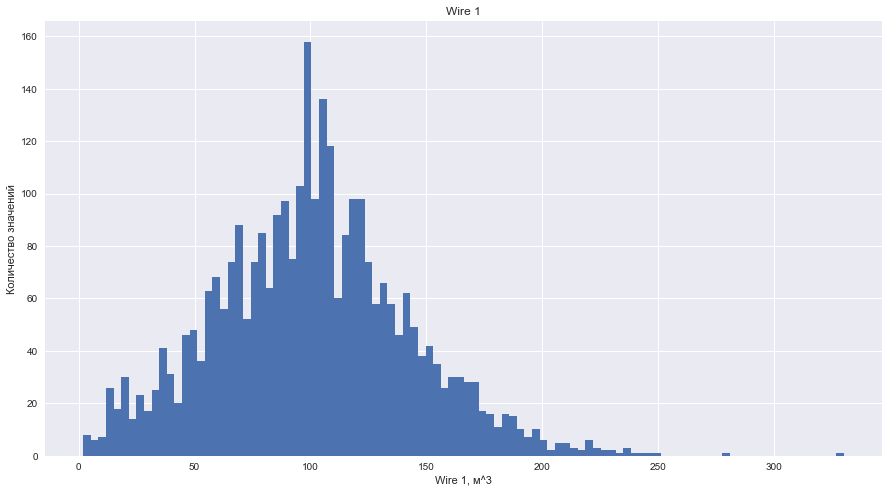

In [46]:
graph(df_wire, "Wire 1", "Wire 1, м^3")

Имеются выбивающиеся значения.

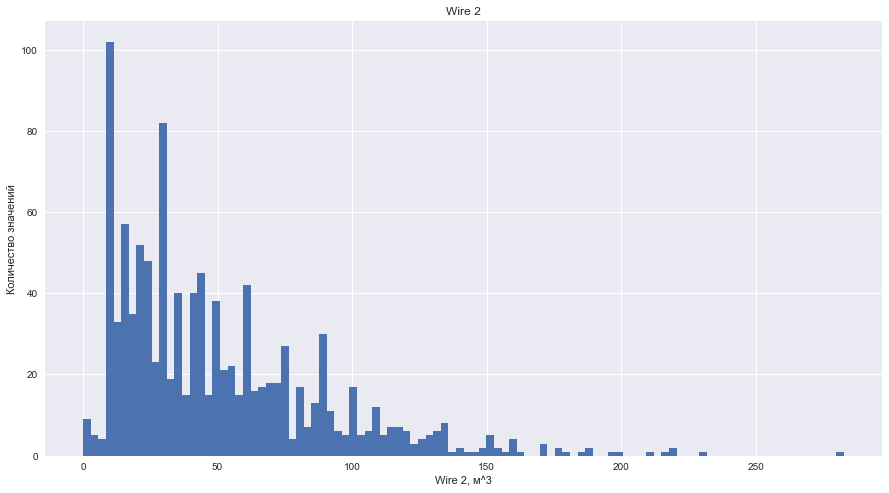

In [47]:
graph(df_wire, "Wire 2", "Wire 2, м^3")

Имеются выбивающиеся значения.

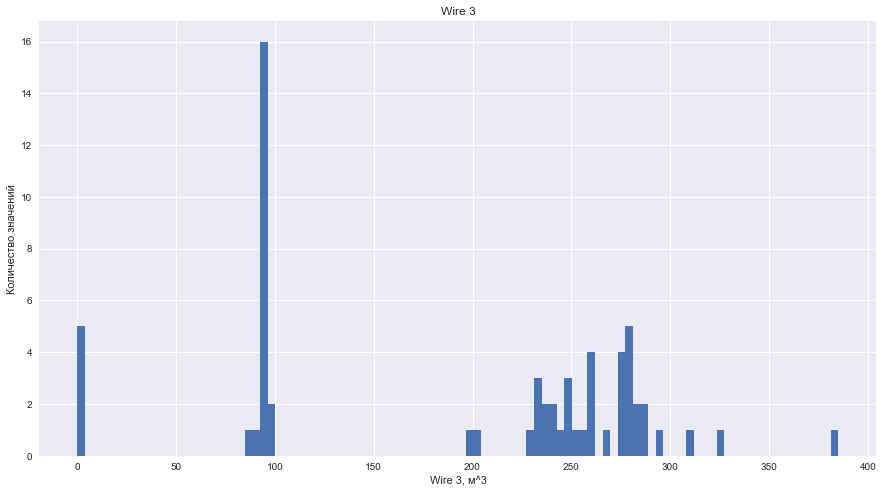

In [48]:
graph(df_wire, "Wire 3", "Wire 3, м^3")

С данными всё в порядке.

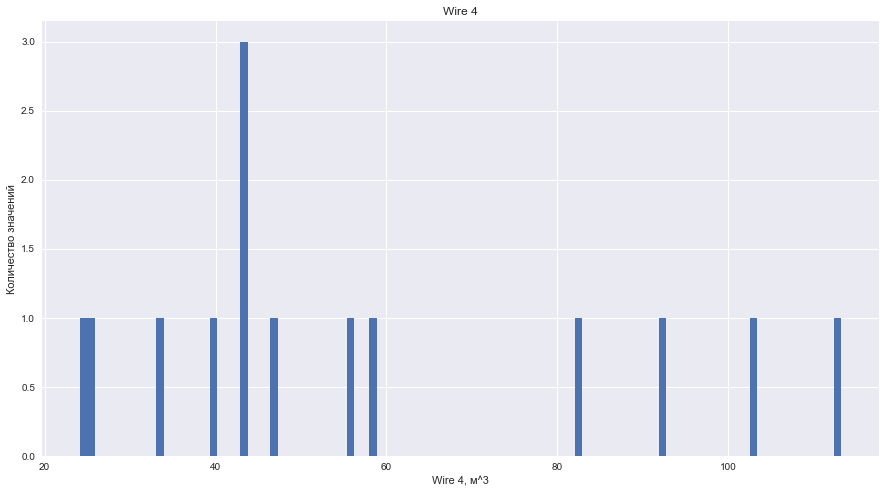

In [49]:
graph(df_wire, "Wire 4", "Wire 4, м^3")

Данные проволочные материалы использовались очень мало.

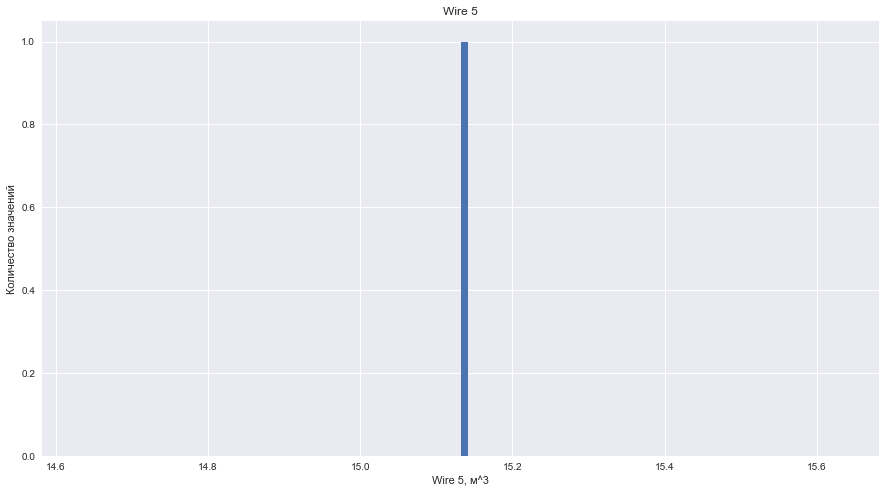

In [50]:
graph(df_wire, "Wire 5", "Wire 5, м^3")

Данные проволочные материалы использовались очень мало.

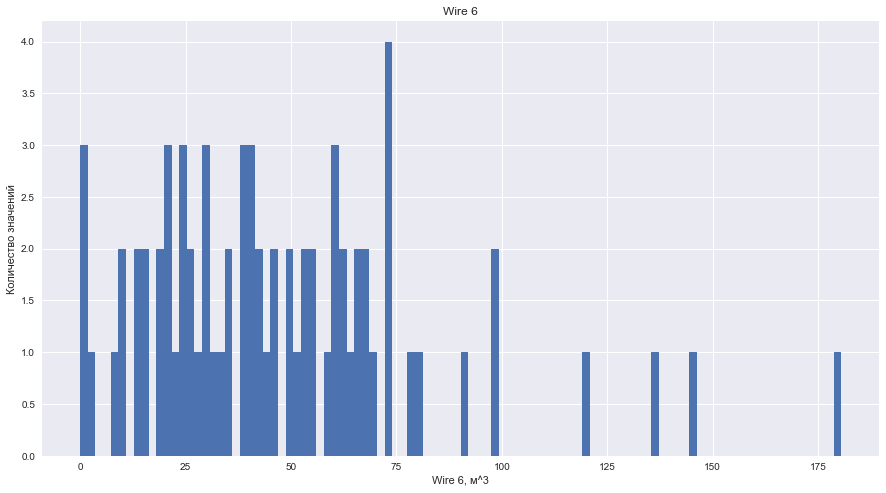

In [51]:
graph(df_wire, "Wire 6", "Wire 6, м^3")

С данными всё в порядке.

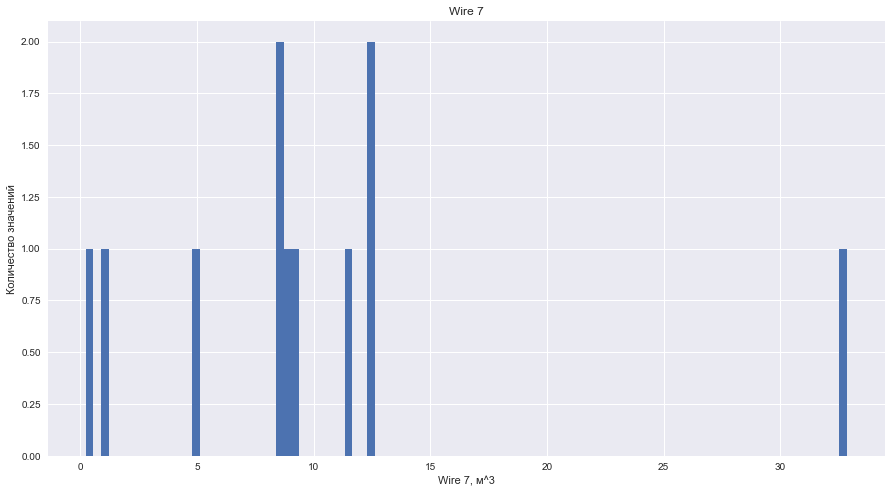

In [52]:
graph(df_wire, "Wire 7", "Wire 7, м^3")

Данные проволочные материалы использовались очень мало.

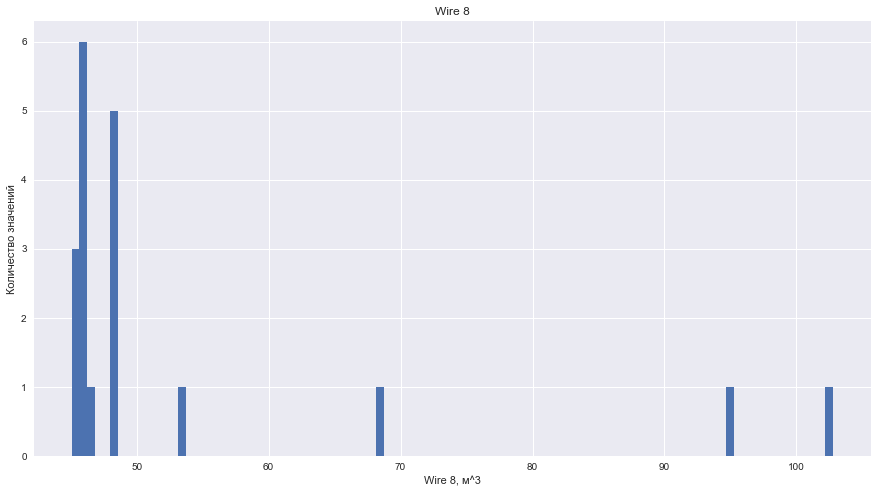

In [53]:
graph(df_wire, "Wire 8", "Wire 8, м^3")

Данные проволочные материалы использовались очень мало.

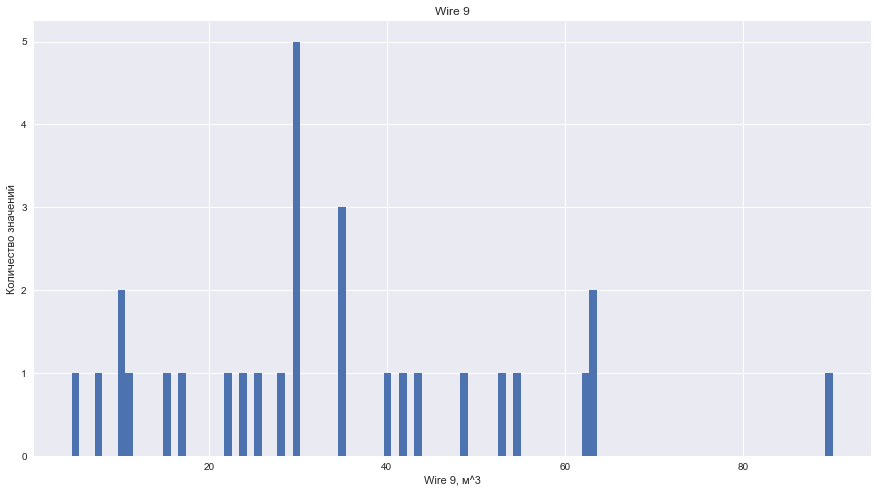

In [54]:
graph(df_wire, "Wire 9", "Wire 9, м^3")

Данные проволочные материалы использовались очень мало.

# 6.1 Вывод по таблице data_wire

1. Необходимо удалить из таблицы малоиспользуемые проволочные материалы.
2. Оставить в таблице по одной строке для каждого ключа, найдя общий объем проволочных материалов.
3. Все выбивающиеся значения необходимо либо заменить, либо удалить ключ.

# 7. Таблица data_wire_time

Изучу таблицу data_wire_time, в которой хранятся данные об объеме проволочных материалов.

In [55]:
try:  
    df_wire_time = pd.read_csv('D:/steel/data_wire_time.csv')
except OSError as e:
    df_wire_time = pd.read_csv('/datasets/final_steel/data_wire_time.csv')
display(df_wire_time.head(10))
display(df_wire_time.tail(10))
display(df_wire_time.sample(10))

,key,Wire 1,Wire 2,Wire 3,Wire 4,Wire 5,Wire 6,Wire 7,Wire 8,Wire 9
0,1,2019-05-03 11:11:41,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
1,2,2019-05-03 11:46:10,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
2,3,2019-05-03 12:13:47,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
3,4,2019-05-03 12:48:05,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
4,5,2019-05-03 13:18:15,2019-05-03 13:32:06,NaN,NaN,NaN,NaN,NaN,NaN,NaN
5,6,2019-05-03 13:59:02,2019-05-03 13:59:54,NaN,NaN,NaN,NaN,NaN,NaN,NaN
6,7,2019-05-03 14:28:46,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
7,8,2019-05-03 15:03:42,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
8,9,2019-05-03 15:42:43,2019-05-03 15:58:12,NaN,NaN,NaN,NaN,NaN,NaN,NaN
9,10,2019-05-03 16:20:25,2019-05-03 16:21:02,NaN,NaN,NaN,NaN,NaN,NaN,NaN


,key,Wire 1,Wire 2,Wire 3,Wire 4,Wire 5,Wire 6,Wire 7,Wire 8,Wire 9
3071,3232,2019-08-31 20:02:30,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
3072,3233,2019-08-31 20:31:24,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
3073,3234,2019-08-31 21:03:52,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
3074,3235,2019-08-31 21:33:01,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
3075,3236,2019-08-31 22:19:43,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
3076,3237,2019-08-31 22:50:20,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
3077,3238,2019-08-31 23:38:24,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
3078,3239,2019-09-01 01:50:43,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
3079,3240,2019-09-01 03:12:02,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
3080,3241,2019-09-01 04:16:01,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN


,key,Wire 1,Wire 2,Wire 3,Wire 4,Wire 5,Wire 6,Wire 7,Wire 8,Wire 9
1721,1808,2019-07-06 15:06:08,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
425,457,2019-05-20 06:39:05,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
2438,2565,NaN,NaN,2019-08-08 11:15:53,NaN,NaN,2019-08-08 11:08:50,2019-08-08 12:21:19,NaN,NaN
818,872,2019-06-04 17:49:27,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
2912,3071,2019-08-26 16:50:38,2019-08-26 16:51:10,NaN,NaN,NaN,NaN,NaN,NaN,NaN
908,968,2019-06-08 00:29:36,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
1279,1348,2019-06-21 01:08:12,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
1654,1734,2019-07-03 23:24:04,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
1412,1484,2019-06-25 22:51:50,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
2996,3155,2019-08-29 05:48:37,2019-08-29 05:49:48,NaN,NaN,NaN,NaN,NaN,NaN,NaN


Таблица состоит из следующих столбцов:

- "key" - содержит номер партии;
- "Wire 1 - Wire 9" - NaN говорит о том, что в конкретную партию конкретные проволочные материалы не добавлялись.

In [56]:
display(df_wire_time.info())

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 3081 entries, 0 to 3080
Data columns (total 10 columns):
 #   Column  Non-Null Count  Dtype 
---  ------  --------------  ----- 
 0   key     3081 non-null   int64 
 1   Wire 1  3055 non-null   object
 2   Wire 2  1079 non-null   object
 3   Wire 3  63 non-null     object
 4   Wire 4  14 non-null     object
 5   Wire 5  1 non-null      object
 6   Wire 6  73 non-null     object
 7   Wire 7  11 non-null     object
 8   Wire 8  19 non-null     object
 9   Wire 9  29 non-null     object
dtypes: int64(1), object(9)
memory usage: 240.8+ KB


None

В таблице присутствует большое количество NaN.

Некоторые проволочные материалы использовались сильно меньше, чем все остальные.

# 7.1 Вывод по таблице data_wire_time

По данной таблице я проверю адекватность данных.

Так как есть сложности со снятием точного времени с датчиков, больше ни для чего эту таблицу я использовать не буду.

   # 8. Общий вывод по анализу данных

Я проанализирован данные, общий вывод таков:
1. Не каждый ключ присутствует во всех таблицах.
2. Необходимо проверить выбросы значений объема материалов, либо заменить, либо удалить ключ.
3. Необходимо добавить в сборную таблицу новые признаки.
4. По каждому ключу в сборной таблице не должны присутствовать NaN, данные из будущего, температура ниже 1500 градусов Цельсия.

# 9. Предобработка данных

Проведу предобработку данных, согласно проведенному ранее анализу.

## 9.1 Таблица df_arc

Удалю ключ с выбросом в столбце с реактивной мощностью.

In [57]:
display(df_arc.loc[df_arc["Реактивная мощность"] < 0])

,key,Начало нагрева дугой,Конец нагрева дугой,Активная мощность,Реактивная мощность
9780,2116,2019-07-24 00:44:48,2019-07-24 00:46:37,0.495782,-715.504924


Отрицательное значение принадлежит ключу 2116.

In [58]:
display(df_arc.loc[df_arc["key"] == 2116])

,key,Начало нагрева дугой,Конец нагрева дугой,Активная мощность,Реактивная мощность
9778,2116,2019-07-24 00:29:52,2019-07-24 00:31:54,0.433266,0.306141
9779,2116,2019-07-24 00:35:50,2019-07-24 00:38:05,0.620265,0.408352
9780,2116,2019-07-24 00:44:48,2019-07-24 00:46:37,0.495782,-715.504924
9781,2116,2019-07-24 00:51:51,2019-07-24 00:52:58,0.299368,0.198796


Удалю все значения ключа 2116.

In [59]:
df_arc = df_arc.drop(index=[9778, 9779, 9780, 9781])

Проверю результат.

In [60]:
display(df_arc.loc[df_arc["key"] == 2116])

,key,Начало нагрева дугой,Конец нагрева дугой,Активная мощность,Реактивная мощность


In [61]:
display(df_arc.loc[df_arc["Реактивная мощность"] < 0])

,key,Начало нагрева дугой,Конец нагрева дугой,Активная мощность,Реактивная мощность


Добавлю новые признаки (длительность нагрева, полная мощность).

Запланированную ранее мощность на единицу времени добавлять не стану, так как у этой величины будет высокая корреляция с другими признаками.

### Длительность нагрева.

Переведу тип данных к формату datetime64[ns].

In [62]:
df_arc['Начало нагрева дугой'] = pd.to_datetime(df_arc['Начало нагрева дугой'], format="%Y-%m-%d %H:%M:%S")

In [63]:
df_arc['Конец нагрева дугой'] = pd.to_datetime(df_arc['Конец нагрева дугой'], format="%Y-%m-%d %H:%M:%S")

Проверю результат.

In [64]:
display(df_arc.info())

<class 'pandas.core.frame.DataFrame'>
Int64Index: 14872 entries, 0 to 14875
Data columns (total 5 columns):
 #   Column                Non-Null Count  Dtype         
---  ------                --------------  -----         
 0   key                   14872 non-null  int64         
 1   Начало нагрева дугой  14872 non-null  datetime64[ns]
 2   Конец нагрева дугой   14872 non-null  datetime64[ns]
 3   Активная мощность     14872 non-null  float64       
 4   Реактивная мощность   14872 non-null  float64       
dtypes: datetime64[ns](2), float64(2), int64(1)
memory usage: 697.1 KB


None

Добавлю столбец "Длительность нагрева".

In [65]:
df_arc['Длительность нагрева'] = (df_arc['Конец нагрева дугой']-df_arc['Начало нагрева дугой']).dt.seconds

In [66]:
display(df_arc.head())
display(df_arc.tail())
display(df_arc.sample())

,key,Начало нагрева дугой,Конец нагрева дугой,Активная мощность,Реактивная мощность,Длительность нагрева
0,1,2019-05-03 11:02:14,2019-05-03 11:06:02,0.976059,0.687084,228
1,1,2019-05-03 11:07:28,2019-05-03 11:10:33,0.805607,0.520285,185
2,1,2019-05-03 11:11:44,2019-05-03 11:14:36,0.744363,0.498805,172
3,1,2019-05-03 11:18:14,2019-05-03 11:24:19,1.659363,1.062669,365
4,1,2019-05-03 11:26:09,2019-05-03 11:28:37,0.692755,0.414397,148


,key,Начало нагрева дугой,Конец нагрева дугой,Активная мощность,Реактивная мощность,Длительность нагрева
14871,3241,2019-09-01 03:58:58,2019-09-01 04:01:35,0.533670,0.354439,157
14872,3241,2019-09-01 04:05:04,2019-09-01 04:08:04,0.676604,0.523631,180
14873,3241,2019-09-01 04:16:41,2019-09-01 04:19:45,0.733899,0.475654,184
14874,3241,2019-09-01 04:31:51,2019-09-01 04:32:48,0.220694,0.145768,57
14875,3241,2019-09-01 04:34:47,2019-09-01 04:36:08,0.306580,0.196708,81


,key,Начало нагрева дугой,Конец нагрева дугой,Активная мощность,Реактивная мощность,Длительность нагрева
4079,876,2019-06-04 20:29:38,2019-06-04 20:31:27,0.419223,0.280307,109


Проверю правильность расчета максимального и минимального значения, считаю этого достаточно.

In [67]:
display(df_arc['Длительность нагрева'].describe())

count    14872.000000
mean       171.688004
std         98.193604
min         11.000000
25%        107.000000
50%        147.000000
75%        214.000000
max        907.000000
Name: Длительность нагрева, dtype: float64

In [68]:
display(df_arc.loc[df_arc['Длительность нагрева'] == 11])

,key,Начало нагрева дугой,Конец нагрева дугой,Активная мощность,Реактивная мощность,Длительность нагрева
4063,873,2019-06-04 18:34:19,2019-06-04 18:34:30,0.040905,0.023569,11
4914,1060,2019-06-11 04:31:57,2019-06-11 04:32:08,0.031630,0.022485,11
5320,1154,2019-06-14 08:35:37,2019-06-14 08:35:48,0.030190,0.026755,11
5596,1216,2019-06-16 08:22:19,2019-06-16 08:22:30,0.030188,0.020806,11
6590,1433,2019-06-23 22:25:11,2019-06-23 22:25:22,0.043912,0.028447,11
7372,1601,2019-06-29 21:45:53,2019-06-29 21:46:04,0.030002,0.026542,11
9162,1987,2019-07-19 06:40:25,2019-07-19 06:40:36,0.045408,0.033172,11
11801,2567,2019-08-08 16:00:04,2019-08-08 16:00:15,0.035852,0.035957,11


In [69]:
display(df_arc.loc[df_arc['Длительность нагрева'] == 907])

,key,Начало нагрева дугой,Конец нагрева дугой,Активная мощность,Реактивная мощность,Длительность нагрева
7799,1689,2019-07-02 18:49:03,2019-07-02 19:04:10,3.731596,2.676388,907


### Полная мощность

Формула полной мощности:

In [70]:
display(Image('http://electrokaprizam.net/f9.gif'))

Добавлю столбец "Полная мощность".

In [71]:
df_arc['Полная мощность'] = np.sqrt((df_arc['Активная мощность'])**2 + (df_arc['Реактивная мощность'])**2)

In [72]:
display(df_arc.head())
display(df_arc.tail())
display(df_arc.sample())

,key,Начало нагрева дугой,Конец нагрева дугой,Активная мощность,Реактивная мощность,Длительность нагрева,Полная мощность
0,1,2019-05-03 11:02:14,2019-05-03 11:06:02,0.976059,0.687084,228,1.193639
1,1,2019-05-03 11:07:28,2019-05-03 11:10:33,0.805607,0.520285,185,0.959010
2,1,2019-05-03 11:11:44,2019-05-03 11:14:36,0.744363,0.498805,172,0.896038
3,1,2019-05-03 11:18:14,2019-05-03 11:24:19,1.659363,1.062669,365,1.970470
4,1,2019-05-03 11:26:09,2019-05-03 11:28:37,0.692755,0.414397,148,0.807239


,key,Начало нагрева дугой,Конец нагрева дугой,Активная мощность,Реактивная мощность,Длительность нагрева,Полная мощность
14871,3241,2019-09-01 03:58:58,2019-09-01 04:01:35,0.533670,0.354439,157,0.640648
14872,3241,2019-09-01 04:05:04,2019-09-01 04:08:04,0.676604,0.523631,180,0.855559
14873,3241,2019-09-01 04:16:41,2019-09-01 04:19:45,0.733899,0.475654,184,0.874560
14874,3241,2019-09-01 04:31:51,2019-09-01 04:32:48,0.220694,0.145768,57,0.264489
14875,3241,2019-09-01 04:34:47,2019-09-01 04:36:08,0.306580,0.196708,81,0.364260


,key,Начало нагрева дугой,Конец нагрева дугой,Активная мощность,Реактивная мощность,Длительность нагрева,Полная мощность
1746,376,2019-05-17 13:55:33,2019-05-17 13:56:42,0.286748,0.190141,69,0.344061


Проверю правильность расчета максимального и минимального значения, считаю этого достаточно.

In [73]:
display(df_arc['Полная мощность'].describe())

count    14872.000000
mean         0.838827
std          0.509882
min          0.036664
25%          0.495346
50%          0.694961
75%          1.066975
max          4.592152
Name: Полная мощность, dtype: float64

In [74]:
display(df_arc.loc[df_arc['Полная мощность'] == df_arc['Полная мощность'].min()])

,key,Начало нагрева дугой,Конец нагрева дугой,Активная мощность,Реактивная мощность,Длительность нагрева,Полная мощность
5596,1216,2019-06-16 08:22:19,2019-06-16 08:22:30,0.030188,0.020806,11,0.036664


In [75]:
display(df_arc.loc[df_arc['Полная мощность'] == df_arc['Полная мощность'].max()])

,key,Начало нагрева дугой,Конец нагрева дугой,Активная мощность,Реактивная мощность,Длительность нагрева,Полная мощность
7799,1689,2019-07-02 18:49:03,2019-07-02 19:04:10,3.731596,2.676388,907,4.592152


Оставлю в таблице по одной строке для каждого ключа, найдя средние мощности и просуммировав время нагрева.

In [76]:
df_all = df_arc.drop(columns = ['Начало нагрева дугой', 'Конец нагрева дугой'], axis = 1)

In [77]:
display(df_all.head())

,key,Активная мощность,Реактивная мощность,Длительность нагрева,Полная мощность
0,1,0.976059,0.687084,228,1.193639
1,1,0.805607,0.520285,185,0.959010
2,1,0.744363,0.498805,172,0.896038
3,1,1.659363,1.062669,365,1.970470
4,1,0.692755,0.414397,148,0.807239


In [78]:
df_all = df_all.groupby("key").agg({"Активная мощность":"mean",
                                    "Реактивная мощность":"mean",
                                    "Длительность нагрева":"sum",
                                    "Полная мощность":"mean"}).reset_index()

In [79]:
display(df_all.head(10))
display(df_all.tail(10))
display(df_all.sample(10))

,key,Активная мощность,Реактивная мощность,Длительность нагрева,Полная мощность
0,1,0.975629,0.636648,1098,1.165279
1,2,0.763150,0.499528,811,0.912304
2,3,0.505176,0.319815,655,0.597907
3,4,0.802313,0.515074,741,0.953741
4,5,0.836793,0.563161,869,1.008939
5,6,0.988777,0.672294,952,1.196709
6,7,0.636844,0.390324,673,0.746944
7,8,0.940689,0.670174,913,1.156847
8,9,0.416390,0.295734,625,0.511070
9,10,0.487270,0.416019,825,0.641957


,key,Активная мощность,Реактивная мощность,Длительность нагрева,Полная мощность
3203,3232,0.754802,0.547152,720,0.932616
3204,3233,0.534245,0.408745,409,0.673144
3205,3234,0.602536,0.427071,315,0.738615
3206,3235,0.616006,0.448044,595,0.762281
3207,3236,0.499871,0.426132,290,0.656946
3208,3237,0.786493,0.565692,909,0.968996
3209,3238,0.702176,0.560394,546,0.898847
3210,3239,0.583344,0.388952,1216,0.701485
3211,3240,0.596817,0.496653,839,0.778371
3212,3241,0.494289,0.339240,659,0.599903


,key,Активная мощность,Реактивная мощность,Длительность нагрева,Полная мощность
741,754,0.627529,0.540511,732,0.830800
1180,1195,0.571895,0.416138,926,0.707617
984,998,0.543301,0.379991,569,0.663121
1243,1258,0.598855,0.453004,734,0.751890
1487,1504,1.010149,0.818952,794,1.301217
2871,2898,0.725697,0.521110,1313,0.893546
2142,2162,0.641695,0.438019,472,0.777170
1858,1875,0.681746,0.518018,512,0.856638
2192,2212,0.900197,0.676072,1387,1.127191
1259,1274,0.477317,0.386820,833,0.616589


In [80]:
display(df_all.info())

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 3213 entries, 0 to 3212
Data columns (total 5 columns):
 #   Column                Non-Null Count  Dtype  
---  ------                --------------  -----  
 0   key                   3213 non-null   int64  
 1   Активная мощность     3213 non-null   float64
 2   Реактивная мощность   3213 non-null   float64
 3   Длительность нагрева  3213 non-null   int64  
 4   Полная мощность       3213 non-null   float64
dtypes: float64(3), int64(2)
memory usage: 125.6 KB


None

## 9.2 Таблица df_bulk

Удалю из таблицы малоиспользуемые вещества. Считаю, что их наличии может повлиять на точность модели худшим образом.

In [81]:
df_bulk = df_bulk.drop(columns = ["Bulk 2", "Bulk 7", "Bulk 8", "Bulk 9", "Bulk 13"], axis = 1)

In [82]:
display(df_bulk.head())

,key,Bulk 1,Bulk 3,Bulk 4,Bulk 5,Bulk 6,Bulk 10,Bulk 11,Bulk 12,Bulk 14,Bulk 15
0,1,NaN,NaN,43.0,NaN,NaN,NaN,NaN,206.0,150.0,154.0
1,2,NaN,NaN,73.0,NaN,NaN,NaN,NaN,206.0,149.0,154.0
2,3,NaN,NaN,34.0,NaN,NaN,NaN,NaN,205.0,152.0,153.0
3,4,NaN,NaN,81.0,NaN,NaN,NaN,NaN,207.0,153.0,154.0
4,5,NaN,NaN,78.0,NaN,NaN,NaN,NaN,203.0,151.0,152.0


Так как важно, чтобы модель работала на реальных данных, выбросы пока трогать не буду. Возможно вернусь к ним после разделения на тренировочную и тестовую выборки.

Оставлю в таблице по одной строке для каждого ключа, найдя общий объем смесей.

Заменю NaN на нули.

In [83]:
df_bulk = df_bulk.fillna(0)

In [84]:
display(df_bulk.head())

,key,Bulk 1,Bulk 3,Bulk 4,Bulk 5,Bulk 6,Bulk 10,Bulk 11,Bulk 12,Bulk 14,Bulk 15
0,1,0.0,0.0,43.0,0.0,0.0,0.0,0.0,206.0,150.0,154.0
1,2,0.0,0.0,73.0,0.0,0.0,0.0,0.0,206.0,149.0,154.0
2,3,0.0,0.0,34.0,0.0,0.0,0.0,0.0,205.0,152.0,153.0
3,4,0.0,0.0,81.0,0.0,0.0,0.0,0.0,207.0,153.0,154.0
4,5,0.0,0.0,78.0,0.0,0.0,0.0,0.0,203.0,151.0,152.0


Проверю есть ли одинаковые значения в столбце 'key'.

In [85]:
display(df_bulk['key'].unique().shape[0])

3129

In [86]:
display(df_bulk['key'].shape[0])

3129

Добавлю новый стобец 'Общий объем смесей'.

In [87]:
df_bulk['Общий объем смесей'] = df_bulk.loc[:,'Bulk 1':'Bulk 15'].sum(axis=1)

In [88]:
display(df_bulk.head(10))
display(df_bulk.tail(10))
display(df_bulk.sample(10))

,key,Bulk 1,Bulk 3,Bulk 4,Bulk 5,Bulk 6,Bulk 10,Bulk 11,Bulk 12,Bulk 14,Bulk 15,Общий объем смесей
0,1,0.0,0.0,43.0,0.0,0.0,0.0,0.0,206.0,150.0,154.0,553.0
1,2,0.0,0.0,73.0,0.0,0.0,0.0,0.0,206.0,149.0,154.0,582.0
2,3,0.0,0.0,34.0,0.0,0.0,0.0,0.0,205.0,152.0,153.0,544.0
3,4,0.0,0.0,81.0,0.0,0.0,0.0,0.0,207.0,153.0,154.0,595.0
4,5,0.0,0.0,78.0,0.0,0.0,0.0,0.0,203.0,151.0,152.0,584.0
5,6,0.0,0.0,117.0,0.0,0.0,0.0,0.0,204.0,201.0,154.0,676.0
6,7,0.0,0.0,117.0,0.0,0.0,0.0,0.0,204.0,152.0,154.0,627.0
7,8,0.0,0.0,99.0,0.0,0.0,0.0,0.0,410.0,252.0,153.0,914.0
8,9,0.0,0.0,117.0,0.0,0.0,0.0,0.0,107.0,99.0,203.0,526.0
9,10,0.0,0.0,0.0,0.0,0.0,0.0,0.0,203.0,102.0,204.0,509.0


,key,Bulk 1,Bulk 3,Bulk 4,Bulk 5,Bulk 6,Bulk 10,Bulk 11,Bulk 12,Bulk 14,Bulk 15,Общий объем смесей
3119,3232,0.0,22.0,0.0,0.0,0.0,0.0,0.0,252.0,92.0,204.0,570.0
3120,3233,0.0,0.0,0.0,0.0,0.0,0.0,0.0,254.0,114.0,204.0,572.0
3121,3234,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,262.0,204.0,466.0
3122,3235,0.0,0.0,0.0,0.0,0.0,0.0,0.0,204.0,118.0,206.0,528.0
3123,3236,0.0,42.0,0.0,0.0,0.0,0.0,0.0,258.0,132.0,208.0,640.0
3124,3237,0.0,170.0,0.0,0.0,0.0,0.0,0.0,252.0,130.0,206.0,758.0
3125,3238,0.0,126.0,0.0,0.0,0.0,0.0,0.0,254.0,108.0,106.0,594.0
3126,3239,0.0,0.0,0.0,0.0,114.0,0.0,0.0,158.0,270.0,88.0,630.0
3127,3240,0.0,0.0,0.0,0.0,26.0,0.0,0.0,0.0,192.0,54.0,272.0
3128,3241,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,180.0,52.0,232.0


,key,Bulk 1,Bulk 3,Bulk 4,Bulk 5,Bulk 6,Bulk 10,Bulk 11,Bulk 12,Bulk 14,Bulk 15,Общий объем смесей
683,716,0.0,0.0,228.0,0.0,0.0,0.0,0.0,0.0,206.0,0.0,434.0
1220,1270,0.0,86.0,175.0,0.0,0.0,0.0,0.0,256.0,99.0,205.0,821.0
2058,2130,0.0,64.0,0.0,0.0,0.0,117.0,0.0,364.0,109.0,226.0,880.0
887,923,0.0,141.0,0.0,0.0,0.0,0.0,0.0,204.0,154.0,203.0,702.0
710,743,0.0,298.0,0.0,0.0,0.0,0.0,0.0,156.0,257.0,104.0,815.0
1879,1942,0.0,122.0,0.0,0.0,0.0,0.0,0.0,360.0,160.0,212.0,854.0
596,626,0.0,0.0,0.0,0.0,170.0,0.0,0.0,0.0,0.0,0.0,170.0
1529,1587,0.0,0.0,0.0,0.0,0.0,0.0,0.0,185.0,190.0,156.0,531.0
1970,2039,0.0,0.0,0.0,0.0,84.0,0.0,0.0,162.0,107.0,206.0,559.0
64,74,0.0,0.0,188.0,0.0,0.0,0.0,0.0,205.0,106.0,203.0,702.0


## 9.3 Таблица df_wire

Удалю из таблицы малоиспользуемые проволочные материалы.

Считаю, что их наличии может повлиять на точность модели худшим образом.

In [89]:
df_wire = df_wire.drop(columns = ["Wire 4", "Wire 5", "Wire 7", "Wire 8", "Wire 9"], axis = 1)

In [90]:
display(df_wire.head())

,key,Wire 1,Wire 2,Wire 3,Wire 6
0,1,60.059998,NaN,NaN,NaN
1,2,96.052315,NaN,NaN,NaN
2,3,91.160157,NaN,NaN,NaN
3,4,89.063515,NaN,NaN,NaN
4,5,89.238236,9.11456,NaN,NaN


Так как важно, чтобы модель работала на реальных данных, выбросы пока трогать не буду. Возможно вернусь к ним после разделения на тренировочную и тестовую выборки.

Оставлю в таблице по одной строке для каждого ключа, найдя общий объем проволочных материалов.

Заменю NaN на нули.

In [91]:
df_wire = df_wire.fillna(0)

In [92]:
display(df_wire.head())

,key,Wire 1,Wire 2,Wire 3,Wire 6
0,1,60.059998,0.00000,0.0,0.0
1,2,96.052315,0.00000,0.0,0.0
2,3,91.160157,0.00000,0.0,0.0
3,4,89.063515,0.00000,0.0,0.0
4,5,89.238236,9.11456,0.0,0.0


Проверю есть ли одинаковые значения в столбце 'key'.

In [93]:
display(df_wire['key'].unique().shape[0])

3081

In [94]:
display(df_wire['key'].shape[0])

3081

Добавлю новый стобец 'Общий объем проволочных материалов'.

In [95]:
df_wire['Общий объем проволочных материалов'] = df_wire.loc[:,'Wire 1':'Wire 6'].sum(axis=1)

In [96]:
display(df_wire.head(10))
display(df_wire.tail(10))
display(df_wire.sample(10))

,key,Wire 1,Wire 2,Wire 3,Wire 6,Общий объем проволочных материалов
0,1,60.059998,0.000000,0.0,0.0,60.059998
1,2,96.052315,0.000000,0.0,0.0,96.052315
2,3,91.160157,0.000000,0.0,0.0,91.160157
3,4,89.063515,0.000000,0.0,0.0,89.063515
4,5,89.238236,9.114560,0.0,0.0,98.352796
5,6,99.109917,9.114560,0.0,0.0,108.224477
6,7,98.061600,0.000000,0.0,0.0,98.061600
7,8,155.282394,0.000000,0.0,0.0,155.282394
8,9,113.393279,9.143681,0.0,0.0,122.536960
9,10,81.244796,12.376000,0.0,0.0,93.620796


,key,Wire 1,Wire 2,Wire 3,Wire 6,Общий объем проволочных материалов
3071,3232,15.069600,0.0,0.0,0.0,15.069600
3072,3233,107.147033,0.0,0.0,0.0,107.147033
3073,3234,110.160957,0.0,0.0,0.0,110.160957
3074,3235,125.099525,0.0,0.0,0.0,125.099525
3075,3236,101.162880,0.0,0.0,0.0,101.162880
3076,3237,38.088959,0.0,0.0,0.0,38.088959
3077,3238,56.128799,0.0,0.0,0.0,56.128799
3078,3239,143.357761,0.0,0.0,0.0,143.357761
3079,3240,34.070400,0.0,0.0,0.0,34.070400
3080,3241,63.117595,0.0,0.0,0.0,63.117595


,key,Wire 1,Wire 2,Wire 3,Wire 6,Общий объем проволочных материалов
359,391,132.490799,0.000000,0.0,0.000000,132.490799
114,130,105.443516,0.000000,0.0,18.086641,123.530157
2963,3122,131.869919,72.745918,0.0,0.000000,204.615837
1870,1961,70.106400,0.000000,0.0,0.000000,70.106400
1284,1353,137.170791,0.000000,0.0,0.000000,137.170791
1945,2041,40.666078,20.146879,0.0,0.000000,60.812957
2259,2377,45.077759,40.203281,0.0,0.000000,85.281040
1072,1139,114.051598,0.000000,0.0,0.000000,114.051598
49,58,73.207679,11.123840,0.0,0.000000,84.331519
2018,2116,75.216965,0.000000,0.0,0.000000,75.216965


## 9.4 Таблицы df_bulk_time, df_wire_time

Проверю нет ли в таблицах 'df_bulk_time' и 'df_wire_time' данных из 'будущего'.

Найду конечные даты замеров температуры.

In [97]:
df_temp_new = copy.deepcopy(df_temp)

In [98]:
df_temp_new['Время замера'] = pd.to_datetime(df_temp_new['Время замера'], format="%Y-%m-%d %H:%M:%S")

In [99]:
display(df_temp_new.info())

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 15907 entries, 0 to 15906
Data columns (total 3 columns):
 #   Column        Non-Null Count  Dtype         
---  ------        --------------  -----         
 0   key           15907 non-null  int64         
 1   Время замера  15907 non-null  datetime64[ns]
 2   Температура   13006 non-null  float64       
dtypes: datetime64[ns](1), float64(1), int64(1)
memory usage: 372.9 KB


None

In [100]:
df_temp_new = df_temp_new.groupby("key").agg({"Время замера":"last"}).reset_index()

In [101]:
display(df_temp_new.head(10))
display(df_temp_new.tail(10))
display(df_temp_new.sample(10))

,key,Время замера
0,1,2019-05-03 11:30:39
1,2,2019-05-03 11:59:12
2,3,2019-05-03 12:34:57
3,4,2019-05-03 12:59:25
4,5,2019-05-03 13:36:01
5,6,2019-05-03 14:12:29
6,7,2019-05-03 14:42:37
7,8,2019-05-03 15:22:52
8,9,2019-05-03 16:01:16
9,10,2019-05-03 16:36:08


,key,Время замера
3206,3232,2019-08-31 20:17:12
3207,3233,2019-08-31 20:47:24
3208,3234,2019-08-31 21:15:28
3209,3235,2019-08-31 22:00:25
3210,3236,2019-08-31 22:31:42
3211,3237,2019-08-31 23:05:43
3212,3238,2019-08-31 23:43:00
3213,3239,2019-09-01 02:24:15
3214,3240,2019-09-01 03:35:16
3215,3241,2019-09-01 04:38:08


,key,Время замера
3130,3154,2019-08-29 05:27:51
160,163,2019-05-09 11:23:05
1858,1873,2019-07-08 22:09:51
1325,1339,2019-06-20 11:20:26
2100,2117,2019-07-24 01:25:31
3079,3103,2019-08-27 17:14:07
268,271,2019-05-13 14:57:47
3048,3072,2019-08-26 18:19:38
666,675,2019-05-28 06:58:13
2510,2533,2019-08-07 05:03:48


Уберу из таблицы 'df_bulk_time' лишние столбцы.

In [102]:
df_bulk_time = df_bulk_time.drop(columns = ["Bulk 2", "Bulk 7", "Bulk 8", "Bulk 9", "Bulk 13"], axis = 1)

Уберу из таблицы 'df_wire_time' лишние столбцы.

In [103]:
df_wire_time = df_wire_time.drop(columns = ["Wire 4", "Wire 5", "Wire 7", "Wire 8", "Wire 9"], axis = 1)

Соединю таблицы по одинаковым ключам.

In [104]:
time = pd.merge(df_temp_new, df_bulk_time, how="inner", on=["key"])

In [105]:
time_1 = pd.merge(time, df_wire_time, how="inner", on=["key"])

In [106]:
time_1['Bulk 1'] = pd.to_datetime(time_1['Bulk 1'], format="%Y-%m-%d %H:%M:%S")
time_1['Bulk 3'] = pd.to_datetime(time_1['Bulk 3'], format="%Y-%m-%d %H:%M:%S")
time_1['Bulk 4'] = pd.to_datetime(time_1['Bulk 4'], format="%Y-%m-%d %H:%M:%S")
time_1['Bulk 5'] = pd.to_datetime(time_1['Bulk 5'], format="%Y-%m-%d %H:%M:%S")
time_1['Bulk 6'] = pd.to_datetime(time_1['Bulk 6'], format="%Y-%m-%d %H:%M:%S")
time_1['Bulk 10'] = pd.to_datetime(time_1['Bulk 10'], format="%Y-%m-%d %H:%M:%S")
time_1['Bulk 11'] = pd.to_datetime(time_1['Bulk 11'], format="%Y-%m-%d %H:%M:%S")
time_1['Bulk 12'] = pd.to_datetime(time_1['Bulk 12'], format="%Y-%m-%d %H:%M:%S")
time_1['Bulk 14'] = pd.to_datetime(time_1['Bulk 14'], format="%Y-%m-%d %H:%M:%S")
time_1['Bulk 15'] = pd.to_datetime(time_1['Bulk 15'], format="%Y-%m-%d %H:%M:%S")
time_1['Wire 1'] = pd.to_datetime(time_1['Wire 1'], format="%Y-%m-%d %H:%M:%S")
time_1['Wire 2'] = pd.to_datetime(time_1['Wire 2'], format="%Y-%m-%d %H:%M:%S")
time_1['Wire 3'] = pd.to_datetime(time_1['Wire 3'], format="%Y-%m-%d %H:%M:%S")
time_1['Wire 6'] = pd.to_datetime(time_1['Wire 6'], format="%Y-%m-%d %H:%M:%S")

In [107]:
display(time_1.info())

<class 'pandas.core.frame.DataFrame'>
Int64Index: 3025 entries, 0 to 3024
Data columns (total 16 columns):
 #   Column        Non-Null Count  Dtype         
---  ------        --------------  -----         
 0   key           3025 non-null   int64         
 1   Время замера  3025 non-null   datetime64[ns]
 2   Bulk 1        252 non-null    datetime64[ns]
 3   Bulk 3        1293 non-null   datetime64[ns]
 4   Bulk 4        1013 non-null   datetime64[ns]
 5   Bulk 5        77 non-null     datetime64[ns]
 6   Bulk 6        572 non-null    datetime64[ns]
 7   Bulk 10       176 non-null    datetime64[ns]
 8   Bulk 11       177 non-null    datetime64[ns]
 9   Bulk 12       2358 non-null   datetime64[ns]
 10  Bulk 14       2711 non-null   datetime64[ns]
 11  Bulk 15       2236 non-null   datetime64[ns]
 12  Wire 1        3000 non-null   datetime64[ns]
 13  Wire 2        1051 non-null   datetime64[ns]
 14  Wire 3        63 non-null     datetime64[ns]
 15  Wire 6        73 non-null     datetime

None

Проверю тот факт, что время в столбце 'Время замера' самое позднее в строке.

Поставлю заглушку.

In [108]:
time_1 = time_1.fillna('1900-05-03 11:21:30')

In [109]:
display(time_1.head())

,key,Время замера,Bulk 1,Bulk 3,Bulk 4,Bulk 5,Bulk 6,Bulk 10,Bulk 11,Bulk 12,Bulk 14,Bulk 15,Wire 1,Wire 2,Wire 3,Wire 6
0,1,2019-05-03 11:30:39,1900-05-03 11:21:30,1900-05-03 11:21:30,2019-05-03 11:21:30,1900-05-03 11:21:30,1900-05-03 11:21:30,1900-05-03 11:21:30,1900-05-03 11:21:30,2019-05-03 11:03:52,2019-05-03 11:03:52,2019-05-03 11:03:52,2019-05-03 11:11:41,1900-05-03 11:21:30,1900-05-03 11:21:30,1900-05-03 11:21:30
1,2,2019-05-03 11:59:12,1900-05-03 11:21:30,1900-05-03 11:21:30,2019-05-03 11:46:38,1900-05-03 11:21:30,1900-05-03 11:21:30,1900-05-03 11:21:30,1900-05-03 11:21:30,2019-05-03 11:40:20,2019-05-03 11:40:20,2019-05-03 11:40:20,2019-05-03 11:46:10,1900-05-03 11:21:30,1900-05-03 11:21:30,1900-05-03 11:21:30
2,3,2019-05-03 12:34:57,1900-05-03 11:21:30,1900-05-03 11:21:30,2019-05-03 12:31:06,1900-05-03 11:21:30,1900-05-03 11:21:30,1900-05-03 11:21:30,1900-05-03 11:21:30,2019-05-03 12:09:40,2019-05-03 12:09:40,2019-05-03 12:09:40,2019-05-03 12:13:47,1900-05-03 11:21:30,1900-05-03 11:21:30,1900-05-03 11:21:30
3,4,2019-05-03 12:59:25,1900-05-03 11:21:30,1900-05-03 11:21:30,2019-05-03 12:48:43,1900-05-03 11:21:30,1900-05-03 11:21:30,1900-05-03 11:21:30,1900-05-03 11:21:30,2019-05-03 12:41:24,2019-05-03 12:41:24,2019-05-03 12:41:24,2019-05-03 12:48:05,1900-05-03 11:21:30,1900-05-03 11:21:30,1900-05-03 11:21:30
4,5,2019-05-03 13:36:01,1900-05-03 11:21:30,1900-05-03 11:21:30,2019-05-03 13:18:50,1900-05-03 11:21:30,1900-05-03 11:21:30,1900-05-03 11:21:30,1900-05-03 11:21:30,2019-05-03 13:12:56,2019-05-03 13:12:56,2019-05-03 13:12:56,2019-05-03 13:18:15,2019-05-03 13:32:06,1900-05-03 11:21:30,1900-05-03 11:21:30


In [110]:
time_1['result'] = time_1.loc[:,'Время замера':'Wire 6'].max(axis = 1)

In [111]:
display(time_1.head())

,key,Время замера,Bulk 1,Bulk 3,Bulk 4,Bulk 5,Bulk 6,Bulk 10,Bulk 11,Bulk 12,Bulk 14,Bulk 15,Wire 1,Wire 2,Wire 3,Wire 6,result
0,1,2019-05-03 11:30:39,1900-05-03 11:21:30,1900-05-03 11:21:30,2019-05-03 11:21:30,1900-05-03 11:21:30,1900-05-03 11:21:30,1900-05-03 11:21:30,1900-05-03 11:21:30,2019-05-03 11:03:52,2019-05-03 11:03:52,2019-05-03 11:03:52,2019-05-03 11:11:41,1900-05-03 11:21:30,1900-05-03 11:21:30,1900-05-03 11:21:30,2019-05-03 11:30:39
1,2,2019-05-03 11:59:12,1900-05-03 11:21:30,1900-05-03 11:21:30,2019-05-03 11:46:38,1900-05-03 11:21:30,1900-05-03 11:21:30,1900-05-03 11:21:30,1900-05-03 11:21:30,2019-05-03 11:40:20,2019-05-03 11:40:20,2019-05-03 11:40:20,2019-05-03 11:46:10,1900-05-03 11:21:30,1900-05-03 11:21:30,1900-05-03 11:21:30,2019-05-03 11:59:12
2,3,2019-05-03 12:34:57,1900-05-03 11:21:30,1900-05-03 11:21:30,2019-05-03 12:31:06,1900-05-03 11:21:30,1900-05-03 11:21:30,1900-05-03 11:21:30,1900-05-03 11:21:30,2019-05-03 12:09:40,2019-05-03 12:09:40,2019-05-03 12:09:40,2019-05-03 12:13:47,1900-05-03 11:21:30,1900-05-03 11:21:30,1900-05-03 11:21:30,2019-05-03 12:34:57
3,4,2019-05-03 12:59:25,1900-05-03 11:21:30,1900-05-03 11:21:30,2019-05-03 12:48:43,1900-05-03 11:21:30,1900-05-03 11:21:30,1900-05-03 11:21:30,1900-05-03 11:21:30,2019-05-03 12:41:24,2019-05-03 12:41:24,2019-05-03 12:41:24,2019-05-03 12:48:05,1900-05-03 11:21:30,1900-05-03 11:21:30,1900-05-03 11:21:30,2019-05-03 12:59:25
4,5,2019-05-03 13:36:01,1900-05-03 11:21:30,1900-05-03 11:21:30,2019-05-03 13:18:50,1900-05-03 11:21:30,1900-05-03 11:21:30,1900-05-03 11:21:30,1900-05-03 11:21:30,2019-05-03 13:12:56,2019-05-03 13:12:56,2019-05-03 13:12:56,2019-05-03 13:18:15,2019-05-03 13:32:06,1900-05-03 11:21:30,1900-05-03 11:21:30,2019-05-03 13:36:01


Сравню значение столбца 'result' и 'Время замера'.

In [112]:
time_1['compare'] = time_1['Время замера'] == time_1['result']

In [113]:
display(time_1['compare'].unique())

array([ True, False])

In [114]:
display(time_1['compare'].value_counts())

True     3015
False      10
Name: compare, dtype: int64

In [115]:
display(time_1.loc[time_1["compare"] == False])

,key,Время замера,Bulk 1,Bulk 3,Bulk 4,Bulk 5,Bulk 6,Bulk 10,Bulk 11,Bulk 12,Bulk 14,Bulk 15,Wire 1,Wire 2,Wire 3,Wire 6,result,compare
542,586,2019-05-25 01:28:18,1900-05-03 11:21:30,1900-05-03 11:21:30,2019-05-25 01:29:11,1900-05-03 11:21:30,1900-05-03 11:21:30,1900-05-03 11:21:30,1900-05-03 11:21:30,1900-05-03 11:21:30,1900-05-03 11:21:30,1900-05-03 11:21:30,2019-05-25 01:17:33,1900-05-03 11:21:30,1900-05-03 11:21:30,1900-05-03 11:21:30,2019-05-25 01:29:11,False
1156,1244,2019-06-17 08:45:16,1900-05-03 11:21:30,1900-05-03 11:21:30,2019-06-17 08:49:23,1900-05-03 11:21:30,1900-05-03 11:21:30,1900-05-03 11:21:30,1900-05-03 11:21:30,1900-05-03 11:21:30,1900-05-03 11:21:30,1900-05-03 11:21:30,2019-06-17 08:33:55,2019-06-17 08:49:29,1900-05-03 11:21:30,1900-05-03 11:21:30,2019-06-17 08:49:29,False
1226,1316,2019-06-19 17:34:42,1900-05-03 11:21:30,2019-06-19 17:35:26,1900-05-03 11:21:30,1900-05-03 11:21:30,1900-05-03 11:21:30,1900-05-03 11:21:30,1900-05-03 11:21:30,1900-05-03 11:21:30,1900-05-03 11:21:30,1900-05-03 11:21:30,2019-06-19 17:23:55,1900-05-03 11:21:30,1900-05-03 11:21:30,1900-05-03 11:21:30,2019-06-19 17:35:26,False
1398,1493,2019-06-26 06:47:47,1900-05-03 11:21:30,1900-05-03 11:21:30,1900-05-03 11:21:30,1900-05-03 11:21:30,1900-05-03 11:21:30,2019-06-26 06:51:49,1900-05-03 11:21:30,2019-06-26 05:56:51,2019-06-26 05:56:51,2019-06-26 05:56:51,2019-06-26 06:37:40,1900-05-03 11:21:30,1900-05-03 11:21:30,1900-05-03 11:21:30,2019-06-26 06:51:49,False
1410,1505,2019-06-26 14:14:29,1900-05-03 11:21:30,1900-05-03 11:21:30,1900-05-03 11:21:30,1900-05-03 11:21:30,2019-06-26 14:17:30,1900-05-03 11:21:30,1900-05-03 11:21:30,1900-05-03 11:21:30,1900-05-03 11:21:30,1900-05-03 11:21:30,2019-06-26 14:14:50,2019-06-26 14:18:01,1900-05-03 11:21:30,1900-05-03 11:21:30,2019-06-26 14:18:01,False
1447,1549,2019-06-28 05:32:46,1900-05-03 11:21:30,1900-05-03 11:21:30,2019-06-28 05:33:18,1900-05-03 11:21:30,1900-05-03 11:21:30,1900-05-03 11:21:30,1900-05-03 11:21:30,1900-05-03 11:21:30,2019-06-28 05:17:08,1900-05-03 11:21:30,2019-06-28 05:21:40,1900-05-03 11:21:30,1900-05-03 11:21:30,1900-05-03 11:21:30,2019-06-28 05:33:18,False
1754,1873,2019-07-08 22:09:51,1900-05-03 11:21:30,2019-07-08 22:13:14,1900-05-03 11:21:30,1900-05-03 11:21:30,1900-05-03 11:21:30,1900-05-03 11:21:30,1900-05-03 11:21:30,2019-07-08 21:39:55,2019-07-08 21:39:55,2019-07-08 21:39:55,2019-07-08 22:00:47,1900-05-03 11:21:30,1900-05-03 11:21:30,1900-05-03 11:21:30,2019-07-08 22:13:14,False
2005,2137,2019-07-24 16:53:42,1900-05-03 11:21:30,2019-07-24 16:34:32,2019-07-24 16:53:54,1900-05-03 11:21:30,1900-05-03 11:21:30,1900-05-03 11:21:30,1900-05-03 11:21:30,2019-07-24 16:24:28,2019-07-24 16:24:28,2019-07-24 16:24:28,2019-07-24 16:33:10,2019-07-24 16:35:46,1900-05-03 11:21:30,1900-05-03 11:21:30,2019-07-24 16:53:54,False
2260,2421,2019-08-03 09:06:23,1900-05-03 11:21:30,2019-08-03 08:55:29,1900-05-03 11:21:30,1900-05-03 11:21:30,2019-08-03 08:55:29,1900-05-03 11:21:30,2019-08-03 09:06:24,1900-05-03 11:21:30,2019-08-03 08:49:32,1900-05-03 11:21:30,2019-08-03 08:51:33,2019-08-03 08:54:27,1900-05-03 11:21:30,1900-05-03 11:21:30,2019-08-03 09:06:24,False
2489,2667,2019-08-12 04:35:21,1900-05-03 11:21:30,1900-05-03 11:21:30,1900-05-03 11:21:30,1900-05-03 11:21:30,2019-08-12 04:35:33,1900-05-03 11:21:30,1900-05-03 11:21:30,1900-05-03 11:21:30,2019-08-12 04:23:21,2019-08-12 04:23:21,2019-08-12 04:24:19,1900-05-03 11:21:30,1900-05-03 11:21:30,1900-05-03 11:21:30,2019-08-12 04:35:33,False


Обнаружились 10 замеров из 'будущего'. Удалю эти ключи из таблицы 'df_all'.

In [116]:
df_all = df_all.query("key not in [586, 1244, 1316, 1493, 1505, 1549, 1873, 2137, 2421, 2667]")

In [117]:
display(df_all.info())

<class 'pandas.core.frame.DataFrame'>
Int64Index: 3203 entries, 0 to 3212
Data columns (total 5 columns):
 #   Column                Non-Null Count  Dtype  
---  ------                --------------  -----  
 0   key                   3203 non-null   int64  
 1   Активная мощность     3203 non-null   float64
 2   Реактивная мощность   3203 non-null   float64
 3   Длительность нагрева  3203 non-null   int64  
 4   Полная мощность       3203 non-null   float64
dtypes: float64(3), int64(2)
memory usage: 150.1 KB


None

## 9.5 Таблица df_gas

Так как важно, чтобы модель работала на реальных данных, выбросы пока трогать не буду. Возможно вернусь к ним после разделения на тренировочную и тестовую выборки.

## 9.6 Таблица df_temp

Приведу таблицу к виду - ключ, первый замер температуры, конечный замер температуры.

In [118]:
df_temp_first = df_temp.groupby("key").agg({"Время замера":"first"}).reset_index()

In [119]:
df_temp_firstt = pd.merge(df_temp_first, df_temp, how="left", on=["key", 'Время замера'])

In [120]:
df_temp_firstt = df_temp_firstt.rename(columns={"Температура": "Температура_начальная"})

In [121]:
display(df_temp_firstt.head())

,key,Время замера,Температура_начальная
0,1,2019-05-03 11:16:18,1571.0
1,2,2019-05-03 11:37:27,1581.0
2,3,2019-05-03 12:13:17,1596.0
3,4,2019-05-03 12:52:57,1601.0
4,5,2019-05-03 13:23:19,1576.0


In [122]:
df_temp_last = df_temp.groupby("key").agg({"Время замера":"last"}).reset_index()

In [123]:
df_temp_lastt = pd.merge(df_temp_last, df_temp, how="left", on=["key", 'Время замера'])

In [124]:
df_temp_lastt = df_temp_lastt.rename(columns={"Температура": "Температура_конечная"})

In [125]:
display(df_temp_lastt.head())

,key,Время замера,Температура_конечная
0,1,2019-05-03 11:30:39,1613.0
1,2,2019-05-03 11:59:12,1602.0
2,3,2019-05-03 12:34:57,1599.0
3,4,2019-05-03 12:59:25,1625.0
4,5,2019-05-03 13:36:01,1602.0


Объединю таблицы в одну.

In [126]:
df_temp_all = pd.merge(df_temp_firstt, df_temp_lastt, how="inner", on=["key"])

In [127]:
display(df_temp_all.head(10))
display(df_temp_all.tail(10))
display(df_temp_all.sample(10))

,key,Время замера_x,Температура_начальная,Время замера_y,Температура_конечная
0,1,2019-05-03 11:16:18,1571.0,2019-05-03 11:30:39,1613.0
1,2,2019-05-03 11:37:27,1581.0,2019-05-03 11:59:12,1602.0
2,3,2019-05-03 12:13:17,1596.0,2019-05-03 12:34:57,1599.0
3,4,2019-05-03 12:52:57,1601.0,2019-05-03 12:59:25,1625.0
4,5,2019-05-03 13:23:19,1576.0,2019-05-03 13:36:01,1602.0
5,6,2019-05-03 13:49:24,1543.0,2019-05-03 14:12:29,1596.0
6,7,2019-05-03 14:19:43,1586.0,2019-05-03 14:42:37,1599.0
7,8,2019-05-03 15:07:18,1577.0,2019-05-03 15:22:52,1598.0
8,9,2019-05-03 15:37:03,1587.0,2019-05-03 16:01:16,1592.0
9,10,2019-05-03 16:14:29,1574.0,2019-05-03 16:36:08,1593.0


,key,Время замера_x,Температура_начальная,Время замера_y,Температура_конечная
3206,3232,2019-08-31 19:55:53,1563.0,2019-08-31 20:17:12,NaN
3207,3233,2019-08-31 20:24:14,1597.0,2019-08-31 20:47:24,NaN
3208,3234,2019-08-31 20:54:17,1614.0,2019-08-31 21:15:28,NaN
3209,3235,2019-08-31 21:31:47,1590.0,2019-08-31 22:00:25,NaN
3210,3236,2019-08-31 22:08:13,1607.0,2019-08-31 22:31:42,NaN
3211,3237,2019-08-31 22:44:04,1569.0,2019-08-31 23:05:43,NaN
3212,3238,2019-08-31 23:30:31,1584.0,2019-08-31 23:43:00,NaN
3213,3239,2019-09-01 01:31:47,1598.0,2019-09-01 02:24:15,NaN
3214,3240,2019-09-01 02:39:01,1617.0,2019-09-01 03:35:16,NaN
3215,3241,2019-09-01 04:03:30,1586.0,2019-09-01 04:38:08,NaN


,key,Время замера_x,Температура_начальная,Время замера_y,Температура_конечная
1255,1268,2019-06-18 04:12:27,1619.0,2019-06-18 04:35:04,1597.0
1880,1895,2019-07-09 20:17:35,1582.0,2019-07-09 20:45:46,1585.0
2081,2097,2019-07-23 02:52:41,1616.0,2019-07-23 04:20:22,1605.0
878,890,2019-06-05 05:47:00,1571.0,2019-06-05 06:14:11,1598.0
2922,2946,2019-08-22 11:11:31,1555.0,2019-08-22 11:37:06,NaN
508,514,2019-05-22 13:12:44,1609.0,2019-05-22 13:30:31,1589.0
609,618,2019-05-26 03:01:52,1557.0,2019-05-26 03:18:59,1593.0
1085,1097,2019-06-12 11:24:50,1565.0,2019-06-12 11:56:50,1575.0
187,190,2019-05-10 09:26:08,1606.0,2019-05-10 09:56:30,1594.0
556,564,2019-05-24 06:51:25,1580.0,2019-05-24 07:08:21,1594.0


Ключи, чьи значения температуры ниже 1500 градусов Цельсия, а также NaN исключу из таблицы.

In [128]:
df_temp_all = df_temp_all.dropna()

In [129]:
df_temp_alll = df_temp_all.query('Температура_начальная > 1500 & Температура_конечная > 1500')

In [130]:
display(df_temp_alll.head(10))
display(df_temp_alll.tail(10))
display(df_temp_alll.sample(10))

,key,Время замера_x,Температура_начальная,Время замера_y,Температура_конечная
0,1,2019-05-03 11:16:18,1571.0,2019-05-03 11:30:39,1613.0
1,2,2019-05-03 11:37:27,1581.0,2019-05-03 11:59:12,1602.0
2,3,2019-05-03 12:13:17,1596.0,2019-05-03 12:34:57,1599.0
3,4,2019-05-03 12:52:57,1601.0,2019-05-03 12:59:25,1625.0
4,5,2019-05-03 13:23:19,1576.0,2019-05-03 13:36:01,1602.0
5,6,2019-05-03 13:49:24,1543.0,2019-05-03 14:12:29,1596.0
6,7,2019-05-03 14:19:43,1586.0,2019-05-03 14:42:37,1599.0
7,8,2019-05-03 15:07:18,1577.0,2019-05-03 15:22:52,1598.0
8,9,2019-05-03 15:37:03,1587.0,2019-05-03 16:01:16,1592.0
9,10,2019-05-03 16:14:29,1574.0,2019-05-03 16:36:08,1593.0


,key,Время замера_x,Температура_начальная,Время замера_y,Температура_конечная
2467,2489,2019-08-05 20:30:10,1613.0,2019-08-05 21:02:41,1579.0
2468,2490,2019-08-05 21:55:23,1602.0,2019-08-05 22:27:20,1619.0
2469,2492,2019-08-05 22:41:41,1618.0,2019-08-05 23:19:44,1595.0
2470,2493,2019-08-05 23:37:28,1599.0,2019-08-05 23:59:00,1594.0
2471,2494,2019-08-06 00:12:55,1585.0,2019-08-06 00:23:21,1591.0
2472,2495,2019-08-06 00:35:45,1570.0,2019-08-06 00:54:42,1591.0
2473,2496,2019-08-06 01:02:54,1554.0,2019-08-06 01:29:52,1591.0
2474,2497,2019-08-06 01:41:53,1571.0,2019-08-06 01:53:50,1589.0
2475,2498,2019-08-06 02:03:49,1591.0,2019-08-06 02:25:31,1594.0
2476,2499,2019-08-06 02:40:25,1569.0,2019-08-06 03:00:28,1603.0


,key,Время замера_x,Температура_начальная,Время замера_y,Температура_конечная
30,31,2019-05-04 10:21:12,1601.0,2019-05-04 10:39:20,1602.0
540,548,2019-05-23 17:45:53,1529.0,2019-05-23 18:04:40,1585.0
434,439,2019-05-19 14:25:49,1610.0,2019-05-19 15:31:38,1591.0
1718,1733,2019-07-03 22:52:22,1587.0,2019-07-03 23:13:48,1585.0
662,671,2019-05-28 03:37:14,1613.0,2019-05-28 04:18:11,1593.0
426,431,2019-05-19 08:19:59,1601.0,2019-05-19 08:42:57,1620.0
1458,1473,2019-06-25 14:43:54,1547.0,2019-06-25 15:01:25,1593.0
1229,1242,2019-06-17 06:41:49,1606.0,2019-06-17 07:07:26,1594.0
1679,1694,2019-07-02 19:01:56,1561.0,2019-07-02 19:21:52,1584.0
2270,2288,2019-07-29 14:39:24,1611.0,2019-07-29 15:17:15,1596.0


Найду время между двумя замерами и удалю лишние столбцы.

In [131]:
df_temp_alll['Время замера_x'] = pd.to_datetime(df_temp_alll['Время замера_x'], format="%Y-%m-%d %H:%M:%S")

In [132]:
df_temp_alll['Время замера_y'] = pd.to_datetime(df_temp_alll['Время замера_y'], format="%Y-%m-%d %H:%M:%S")

In [133]:
df_temp_alll['Длительность замера'] = (df_temp_alll['Время замера_y'] - df_temp_alll['Время замера_x']).dt.seconds

In [134]:
df_temp_alll = df_temp_alll.drop(columns = ["Время замера_x", "Время замера_y"], axis = 1)

In [135]:
display(df_temp_alll.head(10))
display(df_temp_alll.tail(10))
display(df_temp_alll.sample(10))

,key,Температура_начальная,Температура_конечная,Длительность замера
0,1,1571.0,1613.0,861
1,2,1581.0,1602.0,1305
2,3,1596.0,1599.0,1300
3,4,1601.0,1625.0,388
4,5,1576.0,1602.0,762
5,6,1543.0,1596.0,1385
6,7,1586.0,1599.0,1374
7,8,1577.0,1598.0,934
8,9,1587.0,1592.0,1453
9,10,1574.0,1593.0,1299


,key,Температура_начальная,Температура_конечная,Длительность замера
2467,2489,1613.0,1579.0,1951
2468,2490,1602.0,1619.0,1917
2469,2492,1618.0,1595.0,2283
2470,2493,1599.0,1594.0,1292
2471,2494,1585.0,1591.0,626
2472,2495,1570.0,1591.0,1137
2473,2496,1554.0,1591.0,1618
2474,2497,1571.0,1589.0,717
2475,2498,1591.0,1594.0,1302
2476,2499,1569.0,1603.0,1203


,key,Температура_начальная,Температура_конечная,Длительность замера
1382,1396,1559.0,1596.0,1387
2417,2437,1614.0,1585.0,2494
171,174,1580.0,1579.0,1269
2160,2177,1565.0,1599.0,1388
2291,2309,1583.0,1595.0,1085
1293,1307,1592.0,1587.0,749
2100,2117,1570.0,1578.0,1013
427,432,1588.0,1591.0,850
1226,1239,1588.0,1601.0,1656
452,457,1587.0,1592.0,1543


In [136]:
#к.р.
print(df_temp_alll[df_temp_alll['Температура_начальная']==df_temp_alll['Температура_конечная']].shape)
df_temp_alll[df_temp_alll['Температура_начальная']==df_temp_alll['Температура_конечная']]

(44, 4)


,key,Температура_начальная,Температура_конечная,Длительность замера
60,63,1580.0,1580.0,1341
192,195,1583.0,1583.0,0
194,197,1582.0,1582.0,565
259,262,1596.0,1596.0,3024
276,279,1603.0,1603.0,0
484,489,1593.0,1593.0,679
565,573,1575.0,1575.0,1917
578,586,1594.0,1594.0,775
614,623,1597.0,1597.0,605
623,632,1579.0,1579.0,918


In [137]:
display(df_temp_alll.shape[0])

2473

In [138]:
df_temp_alll = df_temp_alll.query('Температура_начальная != Температура_конечная')

In [139]:
display(df_temp_alll.shape[0])

2429

## 9.7 Общая таблица

Объединю полученные таблицы в одну.

In [140]:
df_new_4 = pd.merge(df_all, df_bulk, how="inner", on=["key"])

In [141]:
df_new_3 = pd.merge(df_new_4, df_wire, how="inner", on=["key"])

In [142]:
df_new_2 = pd.merge(df_new_3, df_gas, how="inner", on=["key"])

In [143]:
df_new = pd.merge(df_new_2, df_temp_alll, how="inner", on=["key"])

In [144]:
display(df_new.head(10))
display(df_new.tail(10))
display(df_new.sample(10))

,key,Активная мощность,Реактивная мощность,Длительность нагрева,Полная мощность,Bulk 1,Bulk 3,Bulk 4,Bulk 5,Bulk 6,...,Общий объем смесей,Wire 1,Wire 2,Wire 3,Wire 6,Общий объем проволочных материалов,Газ 1,Температура_начальная,Температура_конечная,Длительность замера
0,1,0.975629,0.636648,1098,1.165279,0.0,0.0,43.0,0.0,0.0,...,553.0,60.059998,0.000000,0.0,0.0,60.059998,29.749986,1571.0,1613.0,861
1,2,0.763150,0.499528,811,0.912304,0.0,0.0,73.0,0.0,0.0,...,582.0,96.052315,0.000000,0.0,0.0,96.052315,12.555561,1581.0,1602.0,1305
2,3,0.505176,0.319815,655,0.597907,0.0,0.0,34.0,0.0,0.0,...,544.0,91.160157,0.000000,0.0,0.0,91.160157,28.554793,1596.0,1599.0,1300
3,4,0.802313,0.515074,741,0.953741,0.0,0.0,81.0,0.0,0.0,...,595.0,89.063515,0.000000,0.0,0.0,89.063515,18.841219,1601.0,1625.0,388
4,5,0.836793,0.563161,869,1.008939,0.0,0.0,78.0,0.0,0.0,...,584.0,89.238236,9.114560,0.0,0.0,98.352796,5.413692,1576.0,1602.0,762
5,6,0.988777,0.672294,952,1.196709,0.0,0.0,117.0,0.0,0.0,...,676.0,99.109917,9.114560,0.0,0.0,108.224477,11.273392,1543.0,1596.0,1385
6,7,0.636844,0.390324,673,0.746944,0.0,0.0,117.0,0.0,0.0,...,627.0,98.061600,0.000000,0.0,0.0,98.061600,9.836267,1586.0,1599.0,1374
7,8,0.940689,0.670174,913,1.156847,0.0,0.0,99.0,0.0,0.0,...,914.0,155.282394,0.000000,0.0,0.0,155.282394,15.171553,1577.0,1598.0,934
8,9,0.416390,0.295734,625,0.511070,0.0,0.0,117.0,0.0,0.0,...,526.0,113.393279,9.143681,0.0,0.0,122.536960,8.216623,1587.0,1592.0,1453
9,10,0.487270,0.416019,825,0.641957,0.0,0.0,0.0,0.0,0.0,...,509.0,81.244796,12.376000,0.0,0.0,93.620796,6.529891,1574.0,1593.0,1299


,key,Активная мощность,Реактивная мощность,Длительность нагрева,Полная мощность,Bulk 1,Bulk 3,Bulk 4,Bulk 5,Bulk 6,...,Общий объем смесей,Wire 1,Wire 2,Wire 3,Wire 6,Общий объем проволочных материалов,Газ 1,Температура_начальная,Температура_конечная,Длительность замера
2270,2489,0.509670,0.500802,308,0.715113,0.0,0.0,0.0,0.0,100.0,...,480.0,67.136162,0.00000,0.0,0.0,67.136162,10.772628,1613.0,1579.0,1951
2271,2490,0.833892,0.626314,992,1.043805,0.0,50.0,116.0,0.0,0.0,...,885.0,126.060486,0.00000,0.0,0.0,126.060486,20.019526,1602.0,1619.0,1917
2272,2492,0.857095,0.644751,682,1.073486,0.0,74.0,198.0,0.0,0.0,...,945.0,170.046235,0.00000,0.0,0.0,170.046235,11.375063,1618.0,1595.0,2283
2273,2493,0.542426,0.448553,405,0.705242,0.0,115.0,105.0,0.0,0.0,...,779.0,122.172958,0.00000,0.0,0.0,122.172958,9.421691,1599.0,1594.0,1292
2274,2494,0.833013,0.585333,550,1.018204,0.0,0.0,162.0,0.0,0.0,...,591.0,75.042236,0.00000,0.0,0.0,75.042236,3.983053,1585.0,1591.0,626
2275,2495,0.802673,0.590194,723,0.996717,0.0,21.0,0.0,0.0,0.0,...,719.0,89.150879,0.00000,0.0,0.0,89.150879,7.125735,1570.0,1591.0,1137
2276,2496,0.700511,0.468364,940,0.842839,0.0,0.0,63.0,0.0,0.0,...,796.0,114.179527,0.00000,0.0,0.0,114.179527,9.412616,1554.0,1591.0,1618
2277,2497,0.737460,0.617090,569,0.961672,0.0,0.0,85.0,0.0,0.0,...,665.0,94.086723,9.04800,0.0,0.0,103.134723,6.271699,1571.0,1589.0,717
2278,2498,0.681745,0.471086,750,0.828750,0.0,90.0,0.0,0.0,0.0,...,733.0,118.110717,0.00000,0.0,0.0,118.110717,14.953657,1591.0,1594.0,1302
2279,2499,1.024608,0.694466,883,1.238253,0.0,47.0,0.0,0.0,0.0,...,633.0,110.160958,50.00528,0.0,0.0,160.166238,11.336151,1569.0,1603.0,1203


,key,Активная мощность,Реактивная мощность,Длительность нагрева,Полная мощность,Bulk 1,Bulk 3,Bulk 4,Bulk 5,Bulk 6,...,Общий объем смесей,Wire 1,Wire 2,Wire 3,Wire 6,Общий объем проволочных материалов,Газ 1,Температура_начальная,Температура_конечная,Длительность замера
464,512,1.258333,0.791888,1584,1.491549,0.0,62.0,0.0,0.0,264.0,...,1430.0,77.266800,15.200640,0.0,0.0,92.467440,10.539055,1520.0,1597.0,2098
1176,1286,0.590624,0.636008,463,0.871379,0.0,0.0,0.0,0.0,0.0,...,347.0,19.000799,0.000000,0.0,0.0,19.000799,3.683203,1566.0,1581.0,479
2143,2339,0.512138,0.378433,568,0.636820,0.0,0.0,97.0,0.0,0.0,...,467.0,71.067360,0.000000,0.0,0.0,71.067360,10.622953,1588.0,1593.0,1360
61,71,0.579393,0.490324,649,0.759260,0.0,0.0,118.0,0.0,0.0,...,838.0,140.256469,0.000000,0.0,0.0,140.256469,16.210094,1591.0,1589.0,1805
1600,1741,0.644046,0.479191,483,0.803333,0.0,0.0,105.0,0.0,0.0,...,633.0,156.499191,0.000000,0.0,0.0,156.499191,9.715426,1590.0,1587.0,1664
643,701,0.634534,0.425569,699,0.764568,0.0,144.0,0.0,0.0,0.0,...,663.0,182.239197,0.000000,0.0,0.0,182.239197,14.799712,1607.0,1597.0,1960
1036,1140,0.667459,0.477457,832,0.821747,0.0,0.0,103.0,0.0,0.0,...,665.0,117.140396,0.000000,0.0,0.0,117.140396,24.984955,1606.0,1587.0,3064
1086,1191,0.579174,0.449272,613,0.733754,0.0,0.0,54.0,0.0,0.0,...,54.0,97.110001,0.000000,0.0,0.0,97.110001,4.964889,1561.0,1584.0,662
1082,1187,0.923809,0.669316,1349,1.141691,0.0,0.0,75.0,0.0,0.0,...,953.0,185.093994,0.000000,0.0,0.0,185.093994,7.722200,1554.0,1618.0,2234
1262,1377,0.777599,0.558346,1041,0.958302,0.0,159.0,0.0,0.0,0.0,...,862.0,169.135192,220.348953,0.0,0.0,389.484145,7.982939,1571.0,1604.0,1801


In [145]:
display(df_new.info())

<class 'pandas.core.frame.DataFrame'>
Int64Index: 2280 entries, 0 to 2279
Data columns (total 25 columns):
 #   Column                              Non-Null Count  Dtype  
---  ------                              --------------  -----  
 0   key                                 2280 non-null   int64  
 1   Активная мощность                   2280 non-null   float64
 2   Реактивная мощность                 2280 non-null   float64
 3   Длительность нагрева                2280 non-null   int64  
 4   Полная мощность                     2280 non-null   float64
 5   Bulk 1                              2280 non-null   float64
 6   Bulk 3                              2280 non-null   float64
 7   Bulk 4                              2280 non-null   float64
 8   Bulk 5                              2280 non-null   float64
 9   Bulk 6                              2280 non-null   float64
 10  Bulk 10                             2280 non-null   float64
 11  Bulk 11                             2280 no

None

Проверю корреляцию признаков.

In [146]:
corr = df_new.corr()
corr.style.background_gradient(cmap='coolwarm')

,key,Активная мощность,Реактивная мощность,Длительность нагрева,Полная мощность,Bulk 1,Bulk 3,Bulk 4,Bulk 5,Bulk 6,Bulk 10,Bulk 11,Bulk 12,Bulk 14,Bulk 15,Общий объем смесей,Wire 1,Wire 2,Wire 3,Wire 6,Общий объем проволочных материалов,Газ 1,Температура_начальная,Температура_конечная,Длительность замера
key,1.000000,0.003959,0.055300,-0.030348,0.024010,-0.073366,-0.005893,-0.026361,0.036319,0.004880,0.062506,0.037157,0.028181,-0.111746,-0.043115,-0.027945,-0.016854,0.044958,-0.026751,-0.007561,-0.000575,-0.044119,-0.017493,-0.100095,-0.001396
Активная мощность,0.003959,1.000000,0.922912,0.560381,0.988382,0.029595,0.056556,-0.040291,-0.050036,0.048428,-0.017442,0.038867,0.388297,0.346635,0.338696,0.426770,-0.097191,-0.009191,0.004423,0.036506,-0.065327,0.094156,-0.511417,0.210896,0.068733
Реактивная мощность,0.055300,0.922912,1.000000,0.546245,0.970462,0.058965,-0.001001,-0.046008,-0.038515,0.038445,-0.026429,0.048222,0.371457,0.305145,0.298154,0.377735,-0.139354,-0.017551,-0.005985,0.028935,-0.104821,0.068770,-0.480676,0.149076,0.068833
Длительность нагрева,-0.030348,0.560381,0.546245,1.000000,0.566757,0.104547,0.089455,-0.030827,0.012864,0.170058,-0.013706,0.085677,0.462413,0.459887,0.291487,0.532059,0.054752,0.054581,0.032958,0.041952,0.088023,0.395402,-0.388848,0.278619,0.562427
Полная мощность,0.024010,0.988382,0.970462,0.566757,1.000000,0.040499,0.035874,-0.043426,-0.046433,0.046017,-0.021415,0.043571,0.388209,0.337157,0.328040,0.415151,-0.115247,-0.012290,0.000451,0.034411,-0.081603,0.086477,-0.510046,0.190592,0.070242
Bulk 1,-0.073366,0.029595,0.058965,0.104547,0.040499,1.000000,-0.010510,0.041614,0.060572,-0.004606,-0.022931,-0.037080,0.328055,0.207920,-0.001371,0.287231,0.016528,-0.011736,0.020136,0.149340,0.035052,0.239305,0.081220,-0.074941,0.152473
Bulk 3,-0.005893,0.056556,-0.001001,0.089455,0.035874,-0.010510,1.000000,-0.293969,-0.007250,0.067707,-0.084772,-0.010264,0.018496,0.010870,-0.013636,0.217626,0.039508,0.095089,0.005440,0.006795,0.081973,0.056228,-0.111211,-0.035902,0.022064
Bulk 4,-0.026361,-0.040291,-0.046008,-0.030827,-0.043426,0.041614,-0.293969,1.000000,0.028736,-0.251181,-0.084965,-0.117593,0.104870,-0.091907,0.102816,0.129199,0.296743,-0.266955,-0.039464,-0.011406,0.043059,0.017186,0.164448,0.185779,0.000669
Bulk 5,0.036319,-0.050036,-0.038515,0.012864,-0.046433,0.060572,-0.007250,0.028736,1.000000,-0.022118,-0.028884,-0.015658,-0.074055,-0.067341,-0.068608,-0.002041,-0.013282,-0.014188,0.070644,0.204592,0.043427,0.086986,0.079651,-0.028825,0.098755
Bulk 6,0.004880,0.048428,0.038445,0.170058,0.046017,-0.004606,0.067707,-0.251181,-0.022118,1.000000,-0.097671,0.199745,-0.109417,0.183971,-0.107590,0.127569,-0.238628,0.202832,-0.047113,-0.020468,-0.080528,0.146428,-0.131469,-0.188124,0.156886


Оставлю в таблце только полную и реактивную мощность (уберу активную).

Bulk 12 и Wire 1 в таблице оставляю так как это самые часто используемые вещества, без них некорректно составлять модель.

Также удалю столбец key.

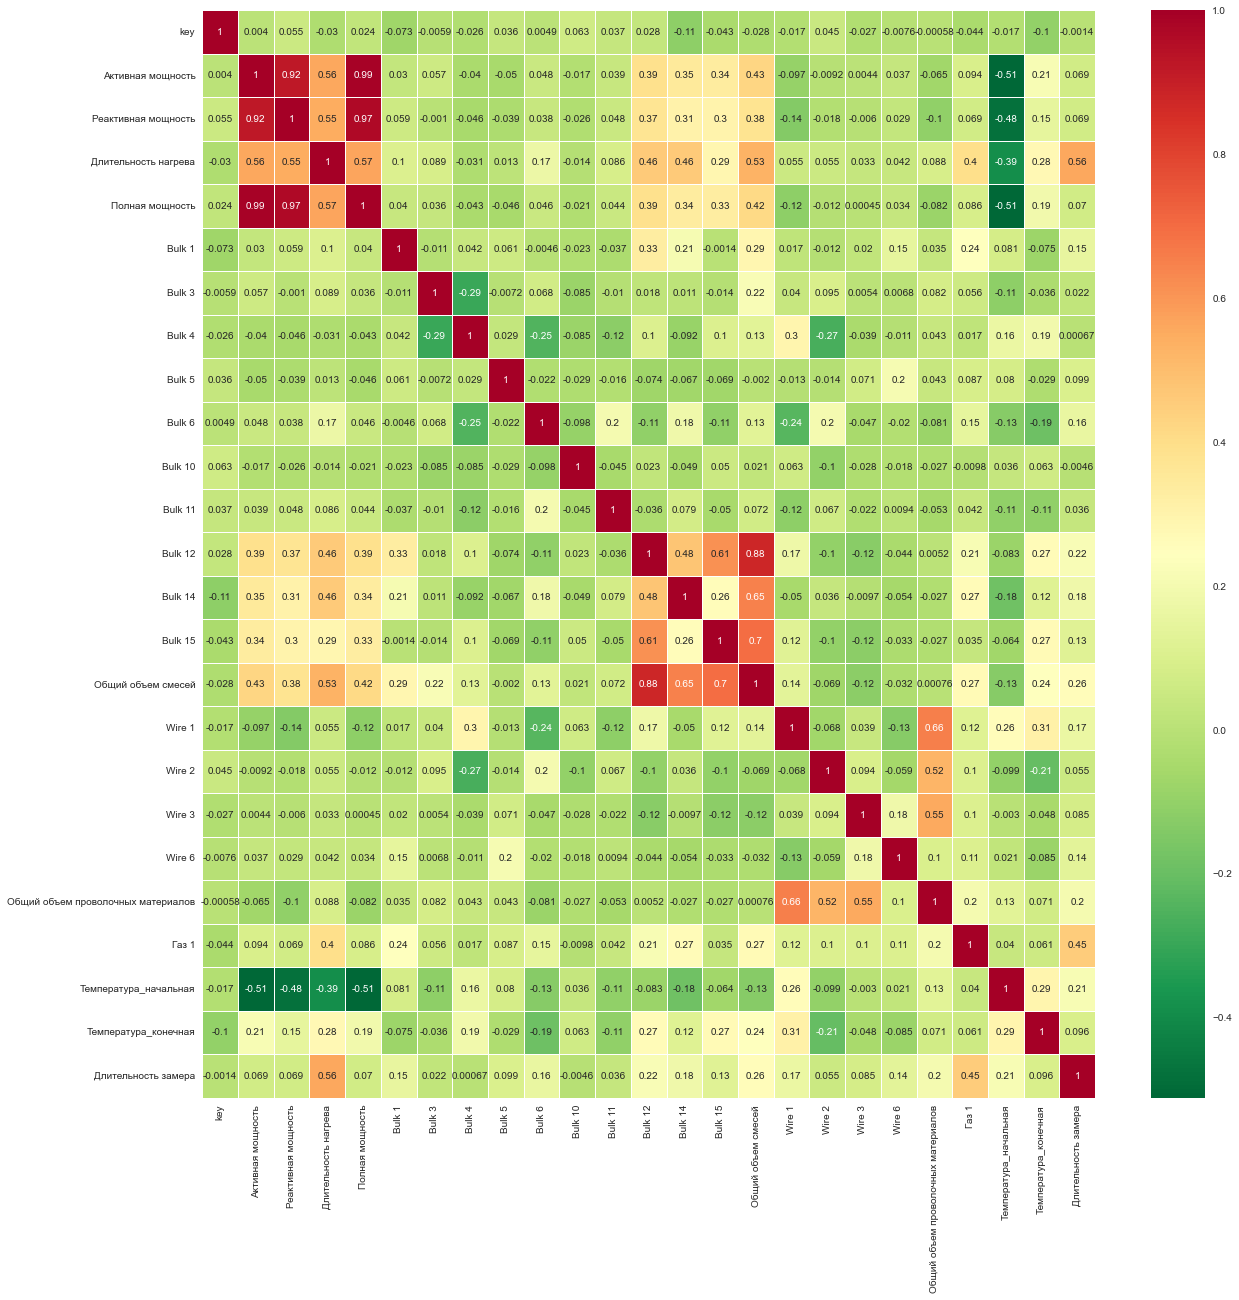

In [147]:
plt.figure(figsize=(20,20))
sns.heatmap(corr, cmap='RdYlGn_r', linewidths=0.5, annot=True)
plt.show()

In [148]:
df_new = df_new.drop(columns = ['key', "Активная мощность"], axis = 1)

In [149]:
display(df_new.head(10))
display(df_new.tail(10))
display(df_new.sample(10))

,Реактивная мощность,Длительность нагрева,Полная мощность,Bulk 1,Bulk 3,Bulk 4,Bulk 5,Bulk 6,Bulk 10,Bulk 11,...,Общий объем смесей,Wire 1,Wire 2,Wire 3,Wire 6,Общий объем проволочных материалов,Газ 1,Температура_начальная,Температура_конечная,Длительность замера
0,0.636648,1098,1.165279,0.0,0.0,43.0,0.0,0.0,0.0,0.0,...,553.0,60.059998,0.000000,0.0,0.0,60.059998,29.749986,1571.0,1613.0,861
1,0.499528,811,0.912304,0.0,0.0,73.0,0.0,0.0,0.0,0.0,...,582.0,96.052315,0.000000,0.0,0.0,96.052315,12.555561,1581.0,1602.0,1305
2,0.319815,655,0.597907,0.0,0.0,34.0,0.0,0.0,0.0,0.0,...,544.0,91.160157,0.000000,0.0,0.0,91.160157,28.554793,1596.0,1599.0,1300
3,0.515074,741,0.953741,0.0,0.0,81.0,0.0,0.0,0.0,0.0,...,595.0,89.063515,0.000000,0.0,0.0,89.063515,18.841219,1601.0,1625.0,388
4,0.563161,869,1.008939,0.0,0.0,78.0,0.0,0.0,0.0,0.0,...,584.0,89.238236,9.114560,0.0,0.0,98.352796,5.413692,1576.0,1602.0,762
5,0.672294,952,1.196709,0.0,0.0,117.0,0.0,0.0,0.0,0.0,...,676.0,99.109917,9.114560,0.0,0.0,108.224477,11.273392,1543.0,1596.0,1385
6,0.390324,673,0.746944,0.0,0.0,117.0,0.0,0.0,0.0,0.0,...,627.0,98.061600,0.000000,0.0,0.0,98.061600,9.836267,1586.0,1599.0,1374
7,0.670174,913,1.156847,0.0,0.0,99.0,0.0,0.0,0.0,0.0,...,914.0,155.282394,0.000000,0.0,0.0,155.282394,15.171553,1577.0,1598.0,934
8,0.295734,625,0.511070,0.0,0.0,117.0,0.0,0.0,0.0,0.0,...,526.0,113.393279,9.143681,0.0,0.0,122.536960,8.216623,1587.0,1592.0,1453
9,0.416019,825,0.641957,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,509.0,81.244796,12.376000,0.0,0.0,93.620796,6.529891,1574.0,1593.0,1299


,Реактивная мощность,Длительность нагрева,Полная мощность,Bulk 1,Bulk 3,Bulk 4,Bulk 5,Bulk 6,Bulk 10,Bulk 11,...,Общий объем смесей,Wire 1,Wire 2,Wire 3,Wire 6,Общий объем проволочных материалов,Газ 1,Температура_начальная,Температура_конечная,Длительность замера
2270,0.500802,308,0.715113,0.0,0.0,0.0,0.0,100.0,0.0,24.0,...,480.0,67.136162,0.00000,0.0,0.0,67.136162,10.772628,1613.0,1579.0,1951
2271,0.626314,992,1.043805,0.0,50.0,116.0,0.0,0.0,0.0,0.0,...,885.0,126.060486,0.00000,0.0,0.0,126.060486,20.019526,1602.0,1619.0,1917
2272,0.644751,682,1.073486,0.0,74.0,198.0,0.0,0.0,0.0,0.0,...,945.0,170.046235,0.00000,0.0,0.0,170.046235,11.375063,1618.0,1595.0,2283
2273,0.448553,405,0.705242,0.0,115.0,105.0,0.0,0.0,0.0,0.0,...,779.0,122.172958,0.00000,0.0,0.0,122.172958,9.421691,1599.0,1594.0,1292
2274,0.585333,550,1.018204,0.0,0.0,162.0,0.0,0.0,0.0,0.0,...,591.0,75.042236,0.00000,0.0,0.0,75.042236,3.983053,1585.0,1591.0,626
2275,0.590194,723,0.996717,0.0,21.0,0.0,0.0,0.0,90.0,0.0,...,719.0,89.150879,0.00000,0.0,0.0,89.150879,7.125735,1570.0,1591.0,1137
2276,0.468364,940,0.842839,0.0,0.0,63.0,0.0,0.0,122.0,0.0,...,796.0,114.179527,0.00000,0.0,0.0,114.179527,9.412616,1554.0,1591.0,1618
2277,0.617090,569,0.961672,0.0,0.0,85.0,0.0,0.0,0.0,0.0,...,665.0,94.086723,9.04800,0.0,0.0,103.134723,6.271699,1571.0,1589.0,717
2278,0.471086,750,0.828750,0.0,90.0,0.0,0.0,0.0,101.0,0.0,...,733.0,118.110717,0.00000,0.0,0.0,118.110717,14.953657,1591.0,1594.0,1302
2279,0.694466,883,1.238253,0.0,47.0,0.0,0.0,0.0,0.0,0.0,...,633.0,110.160958,50.00528,0.0,0.0,160.166238,11.336151,1569.0,1603.0,1203


,Реактивная мощность,Длительность нагрева,Полная мощность,Bulk 1,Bulk 3,Bulk 4,Bulk 5,Bulk 6,Bulk 10,Bulk 11,...,Общий объем смесей,Wire 1,Wire 2,Wire 3,Wire 6,Общий объем проволочных материалов,Газ 1,Температура_начальная,Температура_конечная,Длительность замера
469,0.642015,791,1.073369,0.0,0.0,99.0,0.0,0.0,0.0,0.0,...,679.0,115.268402,0.000000,0.0,0.0,115.268402,8.198734,1565.0,1598.0,893
965,0.530534,818,0.927297,0.0,0.0,0.0,0.0,0.0,113.0,0.0,...,267.0,95.050797,0.000000,0.0,0.0,95.050797,8.814979,1576.0,1592.0,1211
181,0.343109,371,0.580497,0.0,0.0,59.0,0.0,0.0,0.0,0.0,...,472.0,127.458237,15.113280,0.0,0.0,142.571517,7.780773,1586.0,1584.0,1047
1674,0.597282,1002,1.003915,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,458.0,141.429596,0.000000,0.0,0.0,141.429596,8.261487,1595.0,1602.0,1581
296,0.415362,1389,0.710854,48.0,0.0,205.0,0.0,0.0,0.0,0.0,...,1013.0,130.291199,0.000000,0.0,0.0,130.291199,12.855134,1575.0,1596.0,3167
1264,0.603695,770,0.881241,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,603.0,35.146801,0.000000,0.0,0.0,35.146801,4.119832,1571.0,1590.0,343
1026,0.567510,871,0.926013,0.0,286.0,0.0,0.0,0.0,0.0,0.0,...,983.0,115.128002,0.000000,0.0,0.0,115.128002,7.734620,1564.0,1592.0,771
1586,0.697579,882,1.117098,27.0,0.0,50.0,0.0,0.0,0.0,0.0,...,842.0,120.229210,0.000000,0.0,0.0,120.229210,24.660681,1585.0,1593.0,2637
207,0.251565,325,0.438311,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,415.0,71.111040,65.199684,0.0,0.0,136.310724,5.637889,1590.0,1570.0,1221
1127,0.309765,430,0.485609,0.0,66.0,64.0,0.0,0.0,0.0,0.0,...,440.0,157.107605,0.000000,0.0,0.0,157.107605,11.485524,1622.0,1590.0,1769


## 9.8 Вывод по предобработке данных

Данные подготовленны к тестированию различных моделей.

В ходе предобратки данных я оставил только те ключи, для которых имелись полные данные.

Также я добавил следующие признаки - Длительность нагрева, Полная мощность, Общий объем смесей, Общий объем проволочных материалов, Температура начальная, Температура конечная, Длительность замера.

# 10. Тестирование моделей

Разобью данные на тренировочную и тестовую выборки с параметром test_size = 0.25.

In [153]:
features = df_new.drop('Температура_конечная', axis=1)
target = df_new['Температура_конечная']

features_train, features_test, target_train, target_test = train_test_split(
                                                            features, 
                                                            target, 
                                                            test_size=0.25, 
                                                            random_state=RANDOM_STATE)

In [154]:
display(features_train.shape[0])

1710

In [155]:
display(features_test.shape[0])

570

# Обучение моделей

## 10.1 LinearRegression

In [156]:
%%time

model_lr = LinearRegression(fit_intercept = True, normalize = True)

MAE_lr = (cross_val_score(model_lr,  
                          features_train, 
                          target_train, 
                          cv=5, 
                          scoring='neg_mean_absolute_error').mean() * -1)
print('MAE', MAE_lr)

MAE 5.840766480391299
CPU times: total: 93.8 ms
Wall time: 19 ms


## 10.2 RandomForestRegressor

In [157]:
%%time

model_rfr = RandomForestRegressor() 
hyperparams = [{'criterion':['mse'],
                'n_estimators':[100, 200, 300, 400, 500], 
                'random_state':[RANDOM_STATE]}]

clf = GridSearchCV(model_rfr, hyperparams, scoring='neg_mean_absolute_error', cv=5)
clf.fit(features_train, target_train)

param_rfr = clf.best_params_
print('Best :', param_rfr)

MAE_rfr = clf.best_score_
print('Best score :', (MAE_rfr)*-1)

Best : {'criterion': 'mse', 'n_estimators': 400, 'random_state': 80822}
Best score : 6.093795321637427
CPU times: total: 59.4 s
Wall time: 58.5 s


## 10.3 CatBoostRegressor

In [158]:
%%time

model_cbr = CatBoostRegressor(verbose=False, random_state=RANDOM_STATE)

MAE_cbr = (cross_val_score(model_cbr, 
                             features_train, 
                             target_train, 
                             cv=5, 
                             scoring='neg_mean_absolute_error').mean() * -1)
print('MAE', MAE_cbr)

best_cbr = CatBoostRegressor(verbose=False, random_state=RANDOM_STATE).fit(features_train, target_train).get_all_params()
display(best_cbr)

MAE 5.739261770318823


{'nan_mode': 'Min',
 'eval_metric': 'RMSE',
 'iterations': 1000,
 'sampling_frequency': 'PerTree',
 'leaf_estimation_method': 'Newton',
 'grow_policy': 'SymmetricTree',
 'penalties_coefficient': 1,
 'boosting_type': 'Plain',
 'model_shrink_mode': 'Constant',
 'feature_border_type': 'GreedyLogSum',
 'bayesian_matrix_reg': 0.10000000149011612,
 'force_unit_auto_pair_weights': False,
 'l2_leaf_reg': 3,
 'random_strength': 1,
 'rsm': 1,
 'boost_from_average': True,
 'model_size_reg': 0.5,
 'pool_metainfo_options': {'tags': {}},
 'subsample': 0.800000011920929,
 'use_best_model': False,
 'random_seed': 80822,
 'depth': 6,
 'posterior_sampling': False,
 'border_count': 254,
 'classes_count': 0,
 'auto_class_weights': 'None',
 'sparse_features_conflict_fraction': 0,
 'leaf_estimation_backtracking': 'AnyImprovement',
 'best_model_min_trees': 1,
 'model_shrink_rate': 0,
 'min_data_in_leaf': 1,
 'loss_function': 'RMSE',
 'learning_rate': 0.044564999639987946,
 'score_function': 'Cosine',
 'task_

CPU times: total: 1min 16s
Wall time: 7.57 s


## 10.4 LGBMRegressor

In [159]:
%%time

model_lgbmr = LGBMRegressor() 
hyperparams = [{'num_leaves':[10, 12, 14, 16, 18, 20, 22, 24, 26, 28, 30], 
                'learning_rate':[0.001, 0.01, 0.1],
                'random_state':[RANDOM_STATE]}]

clf = GridSearchCV(model_lgbmr, hyperparams, scoring='neg_mean_absolute_error', cv=5)
clf.fit(features_train, target_train)

param_lgbmr = clf.best_params_
print('Best :', param_lgbmr)

MAE_lgbmr = clf.best_score_
print('Best score :', (MAE_lgbmr)*-1)

Best : {'learning_rate': 0.1, 'num_leaves': 28, 'random_state': 80822}
Best score : 5.756189206942856
CPU times: total: 1min 8s
Wall time: 5.72 s


## 10.5 XGBRegressor

In [160]:
%%time

model_xgbr = XGBRegressor() 
hyperparams = [{'learning_rate':[0.0001, 0.001, 0.01, 0.1],
                'random_state':[RANDOM_STATE]}]

clf = GridSearchCV(model_xgbr, hyperparams, scoring='neg_mean_absolute_error', cv=5)
clf.fit(features_train, target_train)

param_xgbr = clf.best_params_
print('Best :', param_lgbmr)

MAE_xgbr = clf.best_score_
print('Best score :', (MAE_xgbr)*-1)

Best : {'learning_rate': 0.1, 'num_leaves': 28, 'random_state': 80822}
Best score : 5.958322339866593
CPU times: total: 10.9 s
Wall time: 916 ms


Я обучил несколько моделей, теперь приступлю к их тестированию на тестовой выборке.

In [161]:
index = ['LinearRegression',
         'RandomForestRegressor',
         'CatBoostRegressor',
         'LGBMRegressor',
         'XGBRegressor']
data = {'MAE тренировочное':[MAE_lr,
                     (MAE_rfr)*-1,
                     MAE_cbr,
                     (MAE_lgbmr)*-1,
                     (MAE_xgbr)*-1]}

all_models = pd.DataFrame(data=data, index=index)
display(all_models)

,MAE тренировочное
LinearRegression,5.840766
RandomForestRegressor,6.093795
CatBoostRegressor,5.739262
LGBMRegressor,5.756189
XGBRegressor,5.958322


## 10.12 Вывод

Все полученные модели показали наилучшие результаты на тестовой выборке.

Наилучшие результаты показала модель CatBoostRegressor со следующими гиперпараметрами:
<br>
{verbose=False,
<br>
  random_state=RANDOM_STATE,
<br>  
'nan_mode': 'Min',
<br>  
 'eval_metric': 'RMSE',
 <br>  
 'iterations': 1000,
 <br>  
 'sampling_frequency': 'PerTree',
 <br>  
 'leaf_estimation_method': 'Newton',
 <br>  
 'grow_policy': 'SymmetricTree',
 <br>  
 'penalties_coefficient': 1,
 <br>  
 'boosting_type': 'Plain',
 <br>  
 'model_shrink_mode': 'Constant',
 <br>  
 'feature_border_type': 'GreedyLogSum',
 <br>  
 'bayesian_matrix_reg': 0.10000000149011612,
 <br>  
 'force_unit_auto_pair_weights': False,
 <br>  
 'l2_leaf_reg': 3,
 <br>  
 'random_strength': 1,
 <br>  
 'rsm': 1,
 <br>  
 'boost_from_average': True,
 <br>  
 'model_size_reg': 0.5,
 <br>  
 'pool_metainfo_options': {'tags': {}},
 <br>  
 'subsample': 0.800000011920929,
 <br>  
 'use_best_model': False,
 <br>  
 'random_seed': 80822,
 <br>  
 'depth': 6,
 <br>  
 'posterior_sampling': False,
 <br>  
 'border_count': 254,
 <br>  
 'classes_count': 0,
 <br>  
 'auto_class_weights': 'None',
 <br>  
 'sparse_features_conflict_fraction': 0,
 <br>  
 'leaf_estimation_backtracking': 'AnyImprovement',
 <br>  
 'best_model_min_trees': 1,
 <br>  
 'model_shrink_rate': 0,
 <br>  
 'min_data_in_leaf': 1,
 <br>  
 'loss_function': 'RMSE',
 <br>  
 'learning_rate': 0.044564999639987946,
 <br>  
 'score_function': 'Cosine',
 <br>  
 'task_type': 'CPU',
 <br>  
 'leaf_estimation_iterations': 1,
 <br>  
 'bootstrap_type': 'MVS',
 <br>  
 'max_leaves': 64}

# 11 Итоговый вывод

В ходе данной работы я провел подробный анализ данных, который помог мне провести предобработку данных.

В ходе предобработки я добавил следующие новые признаки, для обучения модели - Длительность нагрева, Полная мощность, Общий объем смесей, Общий объем проволочных материалов, Температура начальная, Температура конечная, Длительность замера.

Некоторые признаки пришлось удалить - малоиспользуемые материалы, а также активную и реактивную мощности.

Далее я обучал следующие модели:
- LinearRegression
- RandomForestRegressor
- CatBoostRegressor
- LGBMRegressor
- XGBRegressor

Все модели показали результат MAE на тестовой выборке ниже 6.0, но наилучшей моделью оказалась CatBoostRegressor с результатом MAE на тренировочной выборке = 5.739 и MAE на тестовой выборке = 5.593.

Считаю, что полученная модель позволит металлургическому комбинату ООО «Так закаляем сталь» уменьшить потребление электроэнергии на этапе обработки стали.